In [1]:
import numpy as np
import pandas as pd
#import scipy.stats as stats
import json
import seaborn as sns
import qwikidata
import random
import matplotlib.pyplot as plt
from qwikidata.json_dump import WikidataJsonDump
from qwikidata.linked_data_interface import get_entity_dict_from_api
from qwikidata.sparql import (get_subclasses_of_item,
                              return_sparql_query_results)
from collections import Counter
import ast
from qwikidata.linked_data_interface import LdiResponseNotOk
from qwikidata.entity import WikidataItem, WikidataProperty, WikidataLexeme
import sqlite3
from urllib3.exceptions import MaxRetryError
import threading
import time
import timeit
import traceback
import plotly.graph_objects as go
import tldextract
from urllib.parse import urlparse
import ssl
import languages_and_countries
from samplesize import sampleSize
import importlib

class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

ModuleNotFoundError: No module named 'plotly'

In [ ]:
import logging
logging.basicConfig(
    filename='process.log',
    filemode='a+',
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

In [ ]:
wikidata_db = sqlite3.connect('/mnt/data/group3/wikidata/part/wikidata_apr.db')
#wikidata_db = sqlite3.connect('F:/wikidata_apr.db')

sql_cursor = wikidata_db.cursor()

def kill(conn):
    while True: 
        with open('iskill.txt','r') as f:
            time.sleep(1)
            if f.readline().strip() == 'yes':
                print('killed')
                conn.interrupt()
                break
                
th = threading.Thread(target=kill,args=[wikidata_db])
th.start()

In [ ]:
update = False

color_palette_list = ['#009ACD', '#ADD8E6', '#63D1F4', '#0EBFE9',   
                      '#C1F0F6', '#0099CC']

In [ ]:
def get_entity(item_id):
    while True:
        try:
            entity = get_entity_dict_from_api(item_id)
            return entity
        except ConnectionError:
            #traceback.print_exc()
            continue
        except MaxRetryError:
            #traceback.print_exc()
            time.sleep(1)
        except LdiResponseNotOk:
            #traceback.print_exc()
            return 'deleted'

def get_label(item):
    if type(item) == str:        
        entity = get_entity(item)
        if entity == 'deleted':
            return entity
        labels = entity['labels']
    elif type(item) == dict:
        labels = item['labels']
    languages = ['en','fr','es','pt','pt-br','it','de']
    for l in languages:
        if l in labels:
            return labels[l]['value']
    return 'no-label'

def get_datatype(item):
    try:
        if type(item) == str:
            entity = get_entity(item)
            if entity == 'deleted':
                return entity
            datatype = entity['datatype']
        elif type(item) == dict:
            datatype = item['datatype']
        return datatype
    except KeyError:
        return 'none'

def get_claim_values_of(item, property_id):
    if type(item) == str:
        entity = get_entity(item)
        if entity == 'deleted':
            return entity
        claims = entity['claims']
    elif type(item) == dict:
        claims = item['claims']
    if property_id in claims:
        instance_of_claims = claims[property_id]
        return [i['mainsnak']['datavalue']['value']['id'] for i in instance_of_claims]
    else:
        return []
    
def aggregate_other(df, by, count_name='count', other_thr=1):
    df_c = df.copy()
    df_c = df_c[[by,count_name]]
    total_count = df_c[count_name].sum()
    df_c['per'] = df_c[count_name].apply(lambda x: 100*x/total_count)

    other_df_c = df_c[df_c['per'] < other_thr].sum()
    other_df_c[by] = 'other'

    df_c = df_c.append(
        other_df_c, ignore_index=True
    ).sort_values('per',ascending=False).reset_index(drop=True)
    df_c = df_c[df_c['per'] >= other_thr]

    return df_c

# Head 10 of each table

## Claims

In [ ]:
sql_cursor.execute(
    ''' select * from claims limit 10 '''
)
head_10 = pd.DataFrame(sql_cursor.fetchall())
head_10.columns = ['entity_id','claim_id','claim_rank','property_id','datatype','datavalue']
head_10

entity_id                                 claim_id claim_rank property_id  \
0        Q8  Q8$475e48c8-41fa-5739-e46e-27ff20507977     normal       P1245   
1        Q8  q8$0FC7FB9A-B5CA-4762-98AE-1B0BDC1EEF39     normal        P373   
2        Q8  q8$E2EFA381-BA5D-4F52-AF74-660B9A044C1E     normal         P31   
3        Q8  q8$5DB9C22E-4D86-4FB1-AC36-5C75CC806D6A     normal         P31   
4        Q8  Q8$320b6d85-4fc0-a244-ffa5-fa8ac6bf8727     normal         P31   
5        Q8  q8$522798CD-60CD-4EAE-BE3B-365EFD24F2EC     normal        P508   
6        Q8  q8$7dcd6734-4ece-8b37-9386-92e5d4e801cd     normal         P18   
7        Q8  Q8$E805258B-7B18-4558-980E-425F5713DF51     normal        P910   
8        Q8  Q8$A6CF669F-6DD6-49A3-B084-6A31B119A535     normal        P349   
9        Q8  Q8$63214A9F-B2C8-42F9-8DA0-B046A989DDCF     normal        P646   

        datatype                                          datavalue  
0    external-id              {'value': '885155', 'type': 'string'}  
1         string           {'value': 'Happiness', 'type': 'string'}  
2  wikibase-item  {'value': {'entity-type': 'item', 'numeric-id'...  
3  wikibase-item  {'value': {'entity-type': 'item', 'numeric-id'...  
4  wikibase-item  {'value': {'entity-type': 'item', 'numeric-id'...  
5    external-id               {'value': '13163', 'type': 'string'}  
6   commonsMedia  {'value': 'Sweet Baby Kisses Family Love.jpg',...  
7  wikibase-item  {'value': {'entity-type': 'item', 'numeric-id'...  
8    external-id            {'value': '00566227', 'type': 'string'}  
9    external-id           {'value': '/m/016pp7', 'type': 'string'}

## Refs

In [ ]:
sql_cursor.execute(
    ''' select * from refs limit 10 '''
)
head_10 = pd.DataFrame(sql_cursor.fetchall())
head_10.columns = ['reference_id','reference_property_id','reference_index','reference_datatype','reference_value']
head_10

reference_id reference_property_id  \
0  a235ba3d92daf43853b23688674b7ab464b4eea8                  P248   
1  2b00cb481cddcac7623114367489b5c194901c4a                  P248   
2  2b00cb481cddcac7623114367489b5c194901c4a                  P577   
3  b3fd5e254143d8b52cd96cff43af9af5e3a82358                  P143   
4  9a24f7c0208b05d6be97077d855671d1dfdbc0dd                  P143   
5  cf50b45136fd995bef3c409e86b9d66ae8184ff0                  P248   
6  cf50b45136fd995bef3c409e86b9d66ae8184ff0                  P854   
7  cf50b45136fd995bef3c409e86b9d66ae8184ff0                  P813   
8  848c7514b88b1f487526b9556ccde288c97daabd                  P813   
9  f9bf1a1f034ddd51bd9928ac535e0f57d748e2cf                  P248   

  reference_index reference_datatype  \
0               0      wikibase-item   
1               0      wikibase-item   
2               0               time   
3               0      wikibase-item   
4               0      wikibase-item   
5               0      wikibase-item   
6               0                url   
7               0               time   
8               0               time   
9               0      wikibase-item   

                                     reference_value  
0  {'value': {'entity-type': 'item', 'numeric-id'...  
1  {'value': {'entity-type': 'item', 'numeric-id'...  
2  {'value': {'time': '+2013-10-28T00:00:00Z', 't...  
3  {'value': {'entity-type': 'item', 'numeric-id'...  
4  {'value': {'entity-type': 'item', 'numeric-id'...  
5  {'value': {'entity-type': 'item', 'numeric-id'...  
6  {'value': 'http://thes.bncf.firenze.sbn.it/ter...  
7  {'value': {'time': '+2017-10-03T00:00:00Z', 't...  
8  {'value': {'time': '+2018-05-06T00:00:00Z', 't...  
9  {'value': {'entity-type': 'item', 'numeric-id'...

## Claims and Refs joint

In [ ]:
sql_cursor.execute(
    ''' select * from claims_refs limit 10 '''
)
head_10 = pd.DataFrame(sql_cursor.fetchall())
head_10.columns = ['claim_id','reference_id']
head_10

claim_id  \
0   q8$522798CD-60CD-4EAE-BE3B-365EFD24F2EC   
1   Q8$63214A9F-B2C8-42F9-8DA0-B046A989DDCF   
2   Q8$D568DFE7-62F7-42F3-A62C-5535E2F375D3   
3   Q8$056EE957-2C74-4507-9E61-861491C5271C   
4   Q8$98479cc7-4935-829b-da8d-2eb4adb80a6b   
5   Q8$4c54aeba-42dc-f2cf-66db-41e65e7526ef   
6   Q8$23735853-49a7-af22-c0a9-9262cded4ca3   
7   Q8$BA842061-A0D2-4C75-9993-66080F963E8C   
8  q45$8996BD0E-3EF8-4340-9806-7CFB7E5FA364   
9  q45$d8167454-414b-440b-0c30-726977e453c0   

                               reference_id  
0  a235ba3d92daf43853b23688674b7ab464b4eea8  
1  2b00cb481cddcac7623114367489b5c194901c4a  
2  b3fd5e254143d8b52cd96cff43af9af5e3a82358  
3  9a24f7c0208b05d6be97077d855671d1dfdbc0dd  
4  cf50b45136fd995bef3c409e86b9d66ae8184ff0  
5  cf50b45136fd995bef3c409e86b9d66ae8184ff0  
6  848c7514b88b1f487526b9556ccde288c97daabd  
7  f9bf1a1f034ddd51bd9928ac535e0f57d748e2cf  
8  63e3107d14846c406832c49c8f422905489f67ca  
9  8ece5ca44e176c0cd32cb8dc238d7eedd6286bbc

## Total count of claims and references

In [ ]:
if update:
    sql_cursor.execute(
        ''' select count(distinct claim_id) from claims indexed by claim_id_index
     '''
    )
    total_count_claims = sql_cursor.fetchall()[0][0]
else:
    total_count_claims = 195874387
print('There are {} total claims nodes'.format(total_count_claims))

There are 195874387 total claims nodes


In [ ]:
if update:
    sql_cursor.execute(
        ''' select count(distinct claim_id) from claims_refs indexed by claim_refs_claim_index
     '''
    )
    total_count_claims_with_refs = sql_cursor.fetchall()[0][0]
else: 
    total_count_claims_with_refs = 151566485 151566485
print('There are {} total claims nodes with references'.format(total_count_claims_with_refs))

There are 151566485 total claims nodes with references


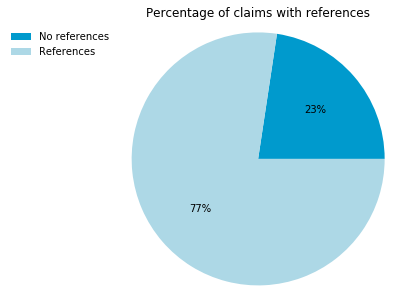

In [ ]:
total_count_claims_no_refs = total_count_claims - total_count_claims_with_refs


fig, ax = plt.subplots(figsize=[5,5])
percentages = [total_count_claims_no_refs, total_count_claims_with_refs]

labels = ['No references','References']

ax.pie(percentages, labels=labels,  
       colors=color_palette_list[0:2], autopct='%1.0f%%', 
       shadow=False, startangle=0,labeldistance=None)
ax.axis('equal')
ax.set_title("Percentage of claims with references")
ax.legend(frameon=False, bbox_to_anchor=(0,1))
plt.show()

In [ ]:
if update:
    sql_cursor.execute(
        ''' 
        select count(distinct reference_id) from refs indexed by reference_id_index
     '''
    )
    total_count_refs = sql_cursor.fetchall()[0][0]
else:
    total_count_refs = 13371626
print('There are {} total references nodes'.format(total_count_refs))
print('For each unique reference node there are {} claims with references'.format(total_count_claims_with_refs/total_count_refs))

There are 13371626 total references nodes
For each unique reference node there are 11.334933014130069 claims with references


# Distribution of kinds of references

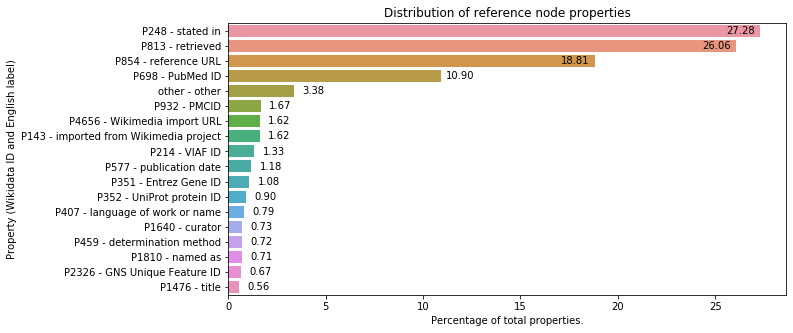

In [ ]:
# One reference node may be connected to many statements. This aggregation is base on statements, meaning that
# if a reference node apears 100 times and has a Stated In property, this property is counted 100 times.
if update:
    sql_cursor.execute(
        ''' select reference_property_id, count(*) as c from refs group by reference_property_id order by c desc
     '''
    )
    reference_property_count = pd.DataFrame(sql_cursor.fetchall())
    reference_property_count.to_csv('data/reference_property_count.csv',index=False)
else:
    reference_property_count = pd.read_csv('data/reference_property_count.csv')
reference_property_count.columns = ['reference_property_id','count']
reference_property_count = reference_property_count[reference_property_count['reference_property_id'] != 'none'].reset_index(drop=True)
    
reference_property_count_c = aggregate_other(reference_property_count, by='reference_property_id', count_name='count', other_thr=0.5)
reference_property_count_c['label'] = reference_property_count_c['reference_property_id'].transform(lambda x : get_label(x) if x!= 'other' else x)

fig, ax = plt.subplots(figsize=[10,5])
percentages = reference_property_count_c['per']
labels = reference_property_count_c.apply(lambda x : ' - '.join([x['reference_property_id'],x['label']]), axis=1)

ax = sns.barplot(y=labels, x=percentages)
ax.set_title("Distribution of reference node properties")
ax.set(ylabel='Property (Wikidata ID and English label)', xlabel='Percentage of total properties.')

for p in ax.patches:
    width = p.get_width()
    ax.text(width + 1 if width < 15 else width - 1 ,
            p.get_y()+p.get_height()/2. + 0.2,
            '{:1.2f}'.format(width),
            ha="center")
    
plt.show()

In [ ]:
interesting_prop_ids = ['P248','P854','P4656','P143']
if update:
    def f(x):
        if x in interesting_prop_ids:
            sql_cursor.execute('''
                select count(distinct reference_id)
                from refs
                where reference_property_id = '{}'
                and reference_value not in ('novalue','somevalue');
            '''.format(x))
            r = sql_cursor.fetchall()[0][0]
            return r/total_count_refs*100
        else:
            return None
    reference_property_count_c['coverage'] = reference_property_count_c['reference_property_id'].apply(f)
else:
    coverages = [85.955687, 59.876331, 5.002615, 5.106148]
    reference_property_count_c['coverage'] = reference_property_count_c['reference_property_id'].apply(
        lambda x : coverages[interesting_prop_ids.index(x)] if x in interesting_prop_ids else None
    )
reference_property_count_c

reference_property_id     count        per  \
0                   P248  11616009  27.276039   
1                   P813  11097790  26.059188   
2                   P854   8011228  18.811502   
3                   P698   4641052  10.897849   
4                  other   1438693   3.378256   
5                   P932    711782   1.671365   
6                  P4656    688617   1.616971   
7                   P143    688556   1.616827   
8                   P214    565093   1.326919   
9                   P577    501496   1.177584   
10                  P351    461572   1.083837   
11                  P352    383065   0.899491   
12                  P407    337227   0.791857   
13                 P1640    311343   0.731078   
14                  P459    308656   0.724768   
15                 P1810    300588   0.705823   
16                 P2326    284344   0.667680   
17                 P1476    239750   0.562967   

                              label   coverage  
0                         stated in  85.955687  
1                         retrieved        NaN  
2                     reference URL  59.876331  
3                         PubMed ID        NaN  
4                             other        NaN  
5                             PMCID        NaN  
6              Wikimedia import URL   5.002615  
7   imported from Wikimedia project   5.106148  
8                           VIAF ID        NaN  
9                  publication date        NaN  
10                   Entrez Gene ID        NaN  
11               UniProt protein ID        NaN  
12         language of work or name        NaN  
13                          curator        NaN  
14             determination method        NaN  
15                         named as        NaN  
16            GNS Unique Feature ID        NaN  
17                            title        NaN

93% of the references with a `Wikimedia import URL` predicate have *only* `Wikimedia import URL` and `imported from Wikimedia project` predicates. That is 622934 references. For those references with a `impoted from Wikimedia project` predicate, 92% have one that and a `Wikimedia import URL` predicate.

In [ ]:
if update:
    sql_cursor.execute(
        ''' 
        select count(*) from refs where 
     '''
    )
    total_refs_values_count = sql_cursor.fetchall()[0][0]
else:
    total_refs_values_count = 42586861
print('There are {} total reference property values'.format(total_refs_values_count))

if update:
    sql_cursor.execute(
        ''' 
        select count(*) from refs where reference_value == 'somevalue'
     '''
    )
    total_refs_somevalues_count = sql_cursor.fetchall()[0][0]
else:
    total_refs_somevalues_count = 24
print('There are {} total reference property values which are somevalue'.format(total_refs_somevalues_count))

if update:
    sql_cursor.execute(
        ''' 
        select count(*) from refs where reference_value == 'novalue'
     '''
    )
    total_refs_novalues_count = sql_cursor.fetchall()[0][0]
else:
    total_refs_novalues_count = 63
print('There are {} total reference property values which are novalue'.format(total_refs_novalues_count))


There are 42586861 total reference property values
There are 24 total reference property values which are somevalue
There are 63 total reference property values which are novalue


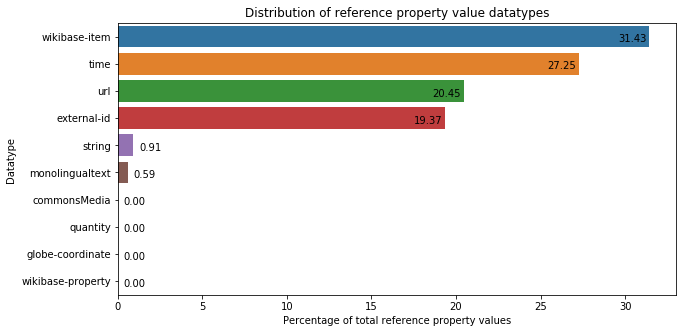

In [ ]:
# Aggregate and show results 
if update:
    sql_cursor.execute(
        ''' select reference_datatype, count(*) as c
        from refs group by reference_datatype
        order by c desc
     '''
    )
    ref_datatype_count = pd.DataFrame(sql_cursor.fetchall())
    ref_datatype_count.to_csv('data/ref_datatype_count.csv',index=False)
else:
    ref_datatype_count = pd.read_csv('data/ref_datatype_count.csv', header=None)
ref_datatype_count.columns = ['reference_datatype','count']

fig, ax = plt.subplots(figsize=[10,5])
percentages = ref_datatype_count['count'].apply(lambda x : 100*x/ref_datatype_count['count'].sum())
labels = ref_datatype_count['reference_datatype']

ax = sns.barplot(y=labels, x=percentages)
ax.set_title("Distribution of reference property value datatypes")
ax.set(ylabel='Datatype ', xlabel='Percentage of total reference property values')

for p in ax.patches:
    width = p.get_width()
    ax.text(width + 1 if width < 15 else width - 1 ,
            p.get_y()+p.get_height()/2. + 0.2,
            '{:1.2f}'.format(width),
            ha="center")
    
plt.show()

# STATED-IN OBJECTS AND SOURCES: DISTRIBUTION OF INSTANCES AND CLASSES

In [ ]:
if update:
    sql_cursor.execute(
        ''' select reference_value
        from refs where reference_property_id = 'P248' 
        and reference_value not in ['novalue','somevalue']
     '''
    )
    stated_in_ids = pd.DataFrame(sql_cursor.fetchall())
    stated_in_ids[0] = stated_in_ids[0].transform(lambda x : json.loads(x.replace("'",'"'))['value']['id'])
    stated_in_ids.columns = ['stated_in_id']
    
    stated_in_ids['count'] = 1
    stated_in_ids = stated_in_ids.groupby('stated_in_id').sum().sort_values('count',ascending=False).reset_index()
    stated_in_ids['label'] = 'none'
    stated_in_ids['instance_of'] = 'none'
    stated_in_ids['subclass_of'] = 'none'
    total = stated_in_ids.shape[0]
    for i in range(total):
        print('{}%'.format((i+1)/total*100) + ' '*15, end='\r')
        if 'none' in list(stated_in_ids.loc[i,['label','instance_of','subclass_of']]):
            entity = get_entity(stated_in_ids.loc[i,'stated_in_id'])
            if type(entity) == str:
                stated_in_ids.loc[i,'label'] = entity
                stated_in_ids.loc[i,'instance_of'] = ''
                stated_in_ids.loc[i,'subclass_of'] = ''
            elif type(entity) == dict:
                stated_in_ids.loc[i,'label'] = str(get_label(entity))
                stated_in_ids.loc[i,'instance_of'] = ','.join(get_claim_values_of(entity,'P31'))
                stated_in_ids.loc[i,'subclass_of'] = ','.join(get_claim_values_of(entity,'P279'))
    stated_in_ids.to_csv('data/stated_in_refs_df.csv',index=False)
else:
    stated_in_ids = pd.read_csv('data/stated_in_refs_df.csv').fillna('')
stated_in_ids

stated_in_id    count  \
0         Q5412157  5338722   
1          Q229883  1958475   
2         Q5188229   862529   
3        Q20641742   455024   
4        Q28018111   308635   
...            ...      ...   
66548    Q29905654        1   
66549    Q29908085        1   
66550    Q29908205        1   
66551    Q29908529        1   
66552      Q995251        1   

                                                   label  \
0                                  Europe PubMed Central   
1                                         PubMed Central   
2                                               Crossref   
3                                              NCBI Gene   
4                                            UniProt-GOA   
...                                                  ...   
66548                                           no-label   
66549  Biometrics of Birds throughout the Greater Car...   
66550                               Visitor Figures 2016   
66551                                           no-label   
66552                         Bryn Mawr Classical Review   

                              instance_of subclass_of  
0                                Q7096323              
1      Q212805,Q1789476,Q1916557,Q7096323              
2                        Q163740,Q1789476              
3                                Q4117139              
4                                Q4117139              
...                                   ...         ...  
66548                            Q3331189              
66549                              Q82753              
66550                           Q66545523              
66551                             Q207184              
66552             Q627517,Q737498,Q773668              

[66553 rows x 5 columns]

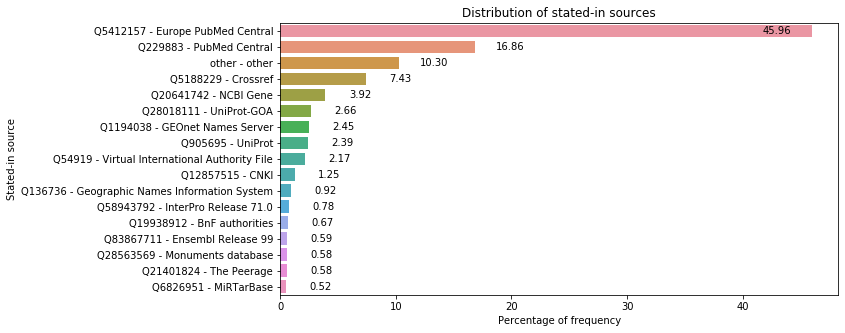

In [ ]:
other_thr = 0.5 #as in 1%

stated_in_ids_c = stated_in_ids.copy()
stated_in_ids_c = stated_in_ids_c.drop(['subclass_of','instance_of'],axis=1)
total_count = stated_in_ids_c['count'].sum()
stated_in_ids_c['per'] = stated_in_ids_c['count'].apply(lambda x: 100*x/total_count)

other_stated_in_ids_c = stated_in_ids_c[stated_in_ids_c['per'] < other_thr].sum()
other_stated_in_ids_c['stated_in_id'] = 'other'
other_stated_in_ids_c['label'] = 'other'

stated_in_ids_c = stated_in_ids_c.append(other_stated_in_ids_c, ignore_index=True).sort_values('per',ascending=False).reset_index(drop=True)
stated_in_ids_c = stated_in_ids_c[stated_in_ids_c['per'] >= other_thr]

fig, ax = plt.subplots(figsize=[10,5])
percentages = stated_in_ids_c['per']
labels = stated_in_ids_c.apply(lambda x : ' - '.join([x['stated_in_id'],x['label']]), axis=1)

ax = sns.barplot(y=labels, x=percentages)
ax.set_title("Distribution of stated-in sources")
ax.set(ylabel='Stated-in source', xlabel='Percentage of frequency')

for p in ax.patches:
    width = p.get_width()
    ax.text(width + 3 if width < 20 else width - 3 ,
            p.get_y()+p.get_height()/2. + 0.2,
            '{:1.2f}'.format(width),
            ha="center")
    
plt.show()

In [ ]:
if update:
    stated_in_ids_instance_of = stated_in_ids.copy()
    stated_in_ids_instance_of = stated_in_ids_instance_of.drop(['label','subclass_of'],axis=1)
    stated_in_ids_instance_of = (stated_in_ids_instance_of.set_index(['stated_in_id', 'count'])
       .apply(lambda x: x.str.split(',').explode())
       .reset_index())

    stated_in_ids_instance_of.drop('stated_in_id',axis=1,inplace=True)
    stated_in_ids_instance_of = stated_in_ids_instance_of[['instance_of','count']]
    stated_in_ids_instance_of = (stated_in_ids_instance_of.groupby('instance_of')
                                 .sum().sort_values('count',ascending=False).reset_index())
    stated_in_ids_instance_of['label'] = 'none'
    stated_in_ids_instance_of['instance_of_of'] = 'none'
    stated_in_ids_instance_of['subclass_of_of'] = 'none'

    total = stated_in_ids_instance_of.shape[0]
    for i in range(total):
        try:
            print('{}%'.format((i+1)/total*100) + ' '*15, end='\r')
            if 'none' == stated_in_ids_instance_of.loc[i,'label']:
                if stated_in_ids_instance_of.loc[i,'instance_of'] != '':
                    entity = get_entity(stated_in_ids_instance_of.loc[i,'instance_of'])
                    stated_in_ids_instance_of.loc[i,'label'] = str(get_label(entity))
                    stated_in_ids_instance_of.loc[i,'instance_of_of'] = ','.join(get_claim_values_of(entity,'P31'))
                    stated_in_ids_instance_of.loc[i,'subclass_of_of'] = ','.join(get_claim_values_of(entity,'P279'))
        except Exception as e:
            print(e,i)
            traceback.print_exc()
            raise
    stated_in_ids_instance_of.to_csv('data/stated_in_ids_instance_of.csv', index=False)
else:
    stated_in_ids_instance_of = pd.read_csv('data/stated_in_ids_instance_of.csv').fillna('')
stated_in_ids_instance_of

instance_of    count                   label instance_of_of  \
0       Q7096323  7311945  open-access repository                  
1       Q1789476  2852960  bibliographic database       Q1789476   
2        Q212805  1985354         digital library      Q25397890   
3       Q1916557  1980859        medical database                  
4       Q4117139  1231664     biological database                  
...          ...      ...                     ...            ...   
1551   Q24634210        1                 podcast                  
1552     Q247073        1        powiat of Poland         Q56061   
1553     Q249556        1         railway company                  
1554    Q2495568        1       universal library                  
1555     Q998672        1               book fair                  

                   subclass_of_of  
0               Q1235234,Q7094076  
1               Q1865123,Q2352616  
2            Q7075,Q1497649,Q8513  
3                        Q1391125  
4                        Q1391125  
...                           ...  
1551           Q11578774,Q7725310  
1552  Q855451,Q15630906,Q13220204  
1553                      Q740752  
1554                        Q7075  
1555                       Q57305  

[1556 rows x 5 columns]

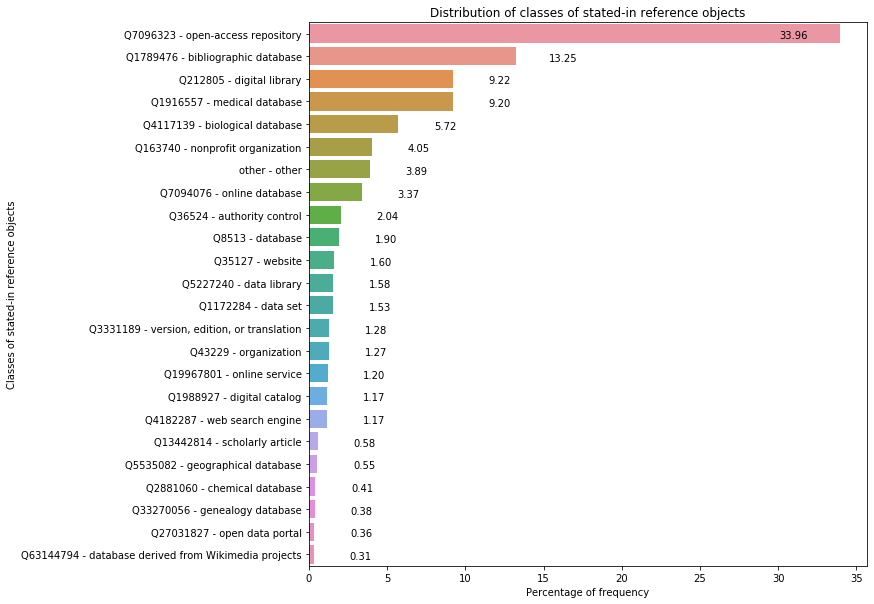

In [ ]:
other_thr = 0.25 #as in 0.25%

stated_in_ids_instance_of_c = stated_in_ids_instance_of.copy()
stated_in_ids_instance_of_c = stated_in_ids_instance_of_c.drop(['instance_of_of','subclass_of_of'],axis=1)
total_count = stated_in_ids_instance_of_c['count'].sum()
stated_in_ids_instance_of_c['per'] = stated_in_ids_instance_of_c['count'].apply(lambda x: 100*x/total_count)

other_stated_in_ids_instance_of_c = stated_in_ids_instance_of_c[stated_in_ids_instance_of_c['per'] < other_thr].sum()
other_stated_in_ids_instance_of_c['instance_of'] = 'other'
other_stated_in_ids_instance_of_c['label'] = 'other'

stated_in_ids_instance_of_c = stated_in_ids_instance_of_c.append(
    other_stated_in_ids_instance_of_c, ignore_index=True
).sort_values('per',ascending=False).reset_index(drop=True)
stated_in_ids_instance_of_c = stated_in_ids_instance_of_c[stated_in_ids_instance_of_c['per'] >= other_thr]

fig, ax = plt.subplots(figsize=[10,10])
percentages = stated_in_ids_instance_of_c['per']
labels = stated_in_ids_instance_of_c.apply(lambda x : ' - '.join([x['instance_of'],x['label']]), axis=1)

ax = sns.barplot(y=labels, x=percentages)
ax.set_title("Distribution of classes of stated-in reference objects")
ax.set(ylabel='Classes of stated-in reference objects', xlabel='Percentage of frequency')

for p in ax.patches:
    width = p.get_width()
    ax.text(width + 3 if width < 20 else width - 3 ,
            p.get_y()+p.get_height()/2. + 0.2,
            '{:1.2f}'.format(width),
            ha="center")
    
plt.show()

## Closer look and some examples

In [ ]:
# In order of largest representation:
stated_in_examples_class, stated_in_examples_labels = [], []
for row in stated_in_ids_instance_of_c.itertuples():
    stated_in_examples_class.append(row.label + '({})'.format(row.instance_of))

    stated_in_Q = stated_in_ids[stated_in_ids['instance_of'].apply(lambda x : row.instance_of in x)]
    examples = list(stated_in_Q.apply(lambda x: x['label'] + '({})'.format(x['stated_in_id']), axis=1))

    if len(stated_in_Q) > 15:
        examples = random.sample(examples,15)
    stated_in_examples_labels.append(','.join(examples))
    
fig = go.Figure(data=[go.Table(
        header=dict(
            values=["Stated-in Class", "Instance Examples"],
            font=dict(size=10),
            align="left"
        ),
        cells=dict(
            values=[stated_in_examples_class, stated_in_examples_labels],
            align = "left")
    )
])

fig.update_layout(
    height=2900,
    showlegend=False,
    title_text="Examples of each stated-in class",
)

fig.show()

# REFERENCE URL: DOMAINS AND LANGUAGES

In [ ]:
if update:
    sql_cursor.execute(
        ''' select reference_value
        from refs
        where reference_property_id = 'P854'
        and reference_value not in ('novalue','somevalue');
     '''
    )
    reference_urls = pd.DataFrame(sql_cursor.fetchall())
    reference_urls.columns = ['reference_url']
    reference_urls['count'] = 1
    reference_urls = reference_urls.groupby('reference_url').sum().sort_values('count',ascending=False).reset_index()
    
    domains_df = reference_urls['reference_url'].transform(tldextract.extract)
    domains_df = pd.DataFrame(domains_df.tolist(), index=domains_df.index)
    reference_urls[['subdomain','domain','suffix']] = domains_df
    
    urlparse_df = reference_urls['reference_url'].transform(urlparse)
    urlparse_df = pd.DataFrame(urlparse_df.tolist(), index=urlparse_df.index)
    reference_urls[['scheme','netloc','path','params','query','fragment']] = urlparse_df
    
    reference_urls.to_csv('reference_urls.csv', index=False)
else:
    reference_urls = pd.read_csv('data/reference_urls_all_df.csv', low_memory=False).fillna('')
reference_urls

reference_url  count subdomain  \
0        http://geonames.usgs.gov/docs/federalcodes/Nat...   6391  geonames   
1                 http://haroldcorwin.net/rc3/rc39b.csv.gz   2282             
2        http://www.pap.hacienda.gob.es/Invente/pagBusc...    397   www.pap   
3        https://administracionelectronica.gob.es/ctt/r...    353             
4        http://www.ebi.ac.uk/QuickGO/annotations?geneP...    170       www   
...                                                    ...    ...       ...   
6503027  https://api.crossref.org/works/10.1038%2FNM049...      1       api   
6503028  https://api.crossref.org/works/10.1038%2FNM049...      1       api   
6503029  https://api.crossref.org/works/10.1038%2FNM049...      1       api   
6503030  https://api.crossref.org/works/10.1038%2FNM049...      1       api   
6503031                               https://紀永.がりはり.com/      1        紀永   

                            domain  suffix scheme  \
0                             usgs     gov   http   
1                     haroldcorwin     net   http   
2                         hacienda  gob.es   http   
3        administracionelectronica  gob.es  https   
4                              ebi   ac.uk   http   
...                            ...     ...    ...   
6503027                   crossref     org  https   
6503028                   crossref     org  https   
6503029                   crossref     org  https   
6503030                   crossref     org  https   
6503031                       がりはり     com  https   

                                   netloc  \
0                       geonames.usgs.gov   
1                        haroldcorwin.net   
2                 www.pap.hacienda.gob.es   
3        administracionelectronica.gob.es   
4                           www.ebi.ac.uk   
...                                   ...   
6503027                  api.crossref.org   
6503028                  api.crossref.org   
6503029                  api.crossref.org   
6503030                  api.crossref.org   
6503031                       紀永.がりはり.com   

                                                      path params  \
0         /docs/federalcodes/NationalFedCodes_20160801.zip          
1                                        /rc3/rc39b.csv.gz          
2                           /Invente/pagBuscadorEntes.aspx          
3        /ctt/resources/Soluciones/238/Descargas/Listad...          
4                                     /QuickGO/annotations          
...                                                    ...    ...   
6503027                        /works/10.1038%2FNM0498-441          
6503028                        /works/10.1038%2FNM0498-391          
6503029                        /works/10.1038%2FNM0497-429          
6503030                        /works/10.1038%2FNM0497-385          
6503031                                                  /          

                                  query fragment  
0                                                 
1                                                 
2                                                 
3                                                 
4        geneProductId=UniProtKB:P07207           
...                                 ...      ...  
6503027                                           
6503028                                           
6503029                                           
6503030                                           
6503031                                           

[6503032 rows x 11 columns]

There are 45079 unique domains.


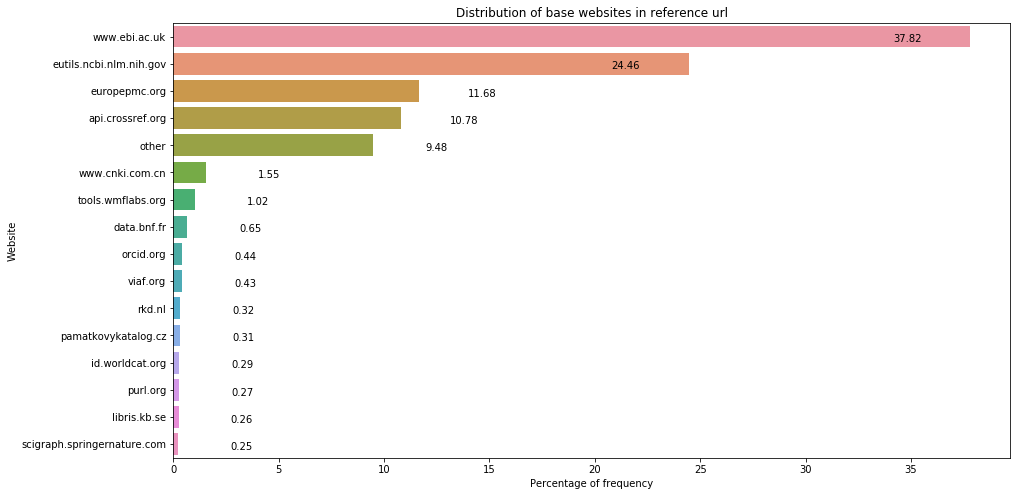

In [ ]:
netlocs_df = reference_urls[['netloc','count']].groupby('netloc').sum().sort_values('count',ascending=False).reset_index()
netlocs_df_agg = aggregate_other(netlocs_df, by='netloc', other_thr=0.25)
print('There are {} unique domains.'.format(netlocs_df.shape[0]))

fig, ax = plt.subplots(figsize=[15,8])

ax = sns.barplot(y='netloc', x='per', data = netlocs_df_agg)
ax.set_title("Distribution of base websites in reference url")
ax.set(ylabel='Website', xlabel='Percentage of frequency')

for p in ax.patches:
    width = p.get_width()
    ax.text(width + 3 if width < 20 else width - 3 ,
            p.get_y()+p.get_height()/2. + 0.2,
            '{:1.2f}'.format(width),
            ha="center")
    
plt.show()

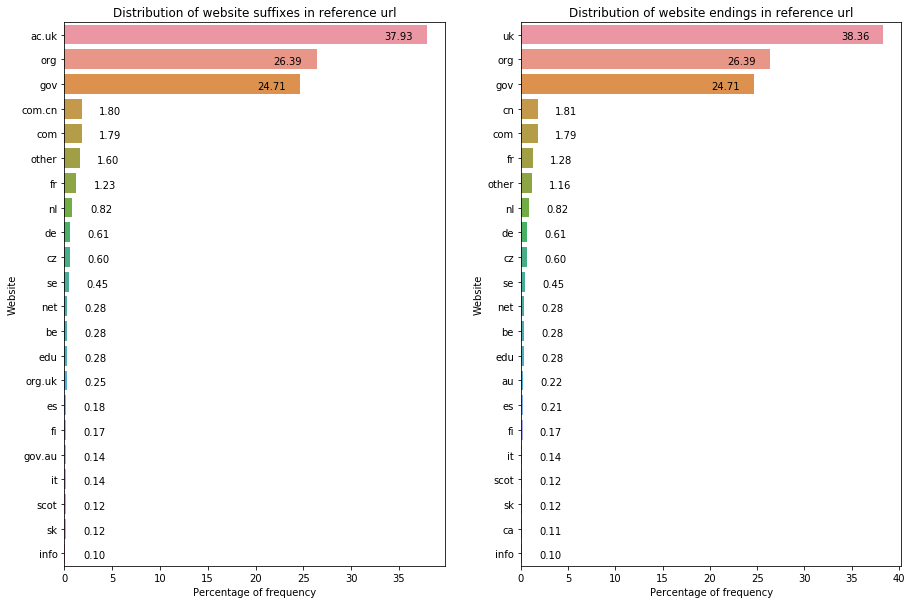

In [ ]:
suffix_df = reference_urls[['suffix','count']].groupby('suffix').sum().sort_values('count',ascending=False).reset_index()
suffix_df['end'] = suffix_df['suffix'].transform(lambda x: x.split('.')[-1])
suffix_df_agg = aggregate_other(suffix_df, by='suffix', other_thr=0.1)

fig, ax = plt.subplots(1,2,figsize=[15,10])

g = sns.barplot(y='suffix', x='per', data = suffix_df_agg, ax=ax[0])
g.set_title("Distribution of website suffixes in reference url")
g.set(ylabel='Website', xlabel='Percentage of frequency')

for p in g.patches:
    width = p.get_width()
    g.text(width + 3 if width < 20 else width - 3 ,
            p.get_y()+p.get_height()/2. + 0.2,
            '{:1.2f}'.format(width),
            ha="center")

suffix_end_df = suffix_df[['end','count']].groupby('end').sum().sort_values('count',ascending=False).reset_index()
suffix_end_df_agg = aggregate_other(suffix_end_df, by='end', other_thr=0.1)
g = sns.barplot(y='end', x='per', data = suffix_end_df_agg, ax=ax[1])
g.set_title("Distribution of website endings in reference url")
g.set(ylabel='Website', xlabel='Percentage of frequency')

for p in g.patches:
    width = p.get_width()
    g.text(width + 3 if width < 20 else width - 3 ,
            p.get_y()+p.get_height()/2. + 0.2,
            '{:1.2f}'.format(width),
            ha="center")
    
plt.show()

In [ ]:
from bs4 import BeautifulSoup
import requests
from urllib import parse
from langdetect import detect
from requests.exceptions import ReadTimeout, TooManyRedirects, ConnectionError, ConnectTimeout,\
    InvalidSchema, InvalidURL
from langdetect.lang_detect_exception import LangDetectException
from urllib3.exceptions import ProtocolError
import urllib.request
import socket
import langid
from requests.packages.urllib3.exceptions import InsecureRequestWarning
requests.packages.urllib3.disable_warnings(InsecureRequestWarning)


def get_url_language(html):
    try:
        #with urllib.request.urlopen(url) as response:
        #    html = response.read()
        soup = BeautifulSoup(html, "lxml")
        [s.decompose() for s in soup("script")]  # remove <script> elements
        if soup.body == None:
            return 'no body'
        body_text = soup.body.get_text()
        return langid.classify(body_text)
        #return detect(body_text)
    except:
        raise
        return 'error'

def get_access_attrs(r, timeout=(10,60*2), as_dict=True):
    if r is None or r == 'None':
        res = {
            'url':r,
            'error_msg':None,
            'code':None,
            'content-type':None,
            'final_url':None,
            'reason':None,
            'language_crawl':None
        }
        return res
    
    chunked_error_retries = 5
    with requests.Session() as s:
        try:
            #resp = urllib.request.urlopen(r, context=context, timeout=timeout)
            while 1:
                headers = {'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/53.0.2785.143 Safari/537.36'}
                resp = s.get(url=r, timeout=timeout, stream=True, verify=False, headers=headers)
                error_msg = 'none'
                if resp.status_code == 429:
                    time.sleep(int(resp.headers['Retry-After']))
                else:
                    break
        except (TooManyRedirects) as e:
            resp = e.response
            error_msg = str(e)
        except (ReadTimeout, ConnectTimeout) as e:
            resp = requests.models.Response()
            resp.reason = 'timeout'
            resp.status_code = 408
            error_msg = str(e)
        except (ConnectionError) as e:
            #print(r)
            #traceback.print_exc()
            resp = requests.models.Response()
            resp.reason = 'connection error'
            resp.status_code = 500
            error_msg = str(e)
        except InvalidSchema as e:
            try:
                resp = requests.models.Response()
                with urllib.request.urlopen(r, timeout=timeout[1]) as resp_urllib:
                    resp.headers = resp_urllib.headers
                    resp.url = resp_urllib.url
                    error_msg = str(e)
                    resp.status_code = resp_urllib.code if hasattr(resp_urllib,'code') else None
                    resp.reason = resp_urllib.reason if hasattr(resp_urllib,'reason') else None
            except urllib.error.URLError as e:
                resp = requests.models.Response()
                resp.reason = 'malformed or invalid url'
                resp.status_code = 400
                error_msg = str(e)
        except (UnicodeError, InvalidURL) as e:
            resp = requests.models.Response()
            resp.reason = 'malformed or invalid url'
            resp.status_code = 400
            error_msg = str(e)
        except (Exception, KeyboardInterrupt) as e:
            #print(r,e)
            #traceback.print_exc()
            raise
        while True:
            try:
                attrs = {
                    'url': r,
                    'error_msg': error_msg,
                    'code': resp.status_code if hasattr(resp,'status_code') else None,
                    'content-type': resp.headers['Content-Type'] if hasattr(resp,'headers') and 'Content-Type' in resp.headers else None,
                    'final_url': resp.url if hasattr(resp,'url') else None,
                    'reason': resp.reason if hasattr(resp,'reason') else None,
                    'language_crawl': None
                }
                
                url_params = parse.parse_qs(parse.urlparse(r).query)
                for langkey in ['srlang','lang','language','srlanguage','p_lang']:
                    if langkey in url_params:
                        attrs['language_crawl'] = (url_params[langkey][0],1)
                    
                if attrs['language_crawl'] == None:
                    if attrs['content-type'] != None:
                        parseable_content_types = ['text/','application/xml','application/json']
                        if any([attrs['content-type'].startswith(p) for p in parseable_content_types]):
                            content = resp.content
                            if content is not None:
                                attrs['language_crawl'] = get_url_language(content)
                            else:
                                attrs['language_crawl'] = 'no content'
                        else:
                            attrs['language_crawl'] = 'not text/html'
                    else:
                        attrs['language_crawl'] = 'no content-type'
                if str(type(resp)) == "<class 'requests.models.Response'>" and hasattr(resp.raw,'close'):
                    resp.close()
                if as_dict:
                    return attrs
                else:
                    return ','.join([str(v) for v in attrs.values()])
                
            except requests.exceptions.ChunkedEncodingError as e:
                chunked_error_retries-=1
                if chunked_error_retries == 0:
                    attrs['language_crawl'] = 'parsing error'
                    return attrs
                #print('pipe problem, retrying')
                resp.close()
                resp = s.get(url=r, timeout=timeout, stream=True, verify=False, headers=headers)
                continue
            except requests.exceptions.ContentDecodingError as e:
                attrs['language_crawl'] = 'parsing error'
                return attrs
            except requests.exceptions.ConnectionError as e:
                attrs['language_crawl'] = 'connection error on reading'
                return attrs
            except Exception as e:
                print(r, e)
                #traceback.print_exc()
                raise
        
#a = reference_urls.loc[:4,'reference_url'].apply(get_access_attrs)
#pd.DataFrame(list(a))

## Checking http status and language for top level domains

In [ ]:
top_domains_df = reference_urls[['scheme','netloc','count']]\
    .groupby(['scheme','netloc']).sum().sort_values('count',ascending=False)\
    .reset_index()
top_domains_df['top_level_domain'] = top_domains_df.apply(
    lambda x: x['scheme'] + '://' + x['netloc'], axis=1
)
total = top_domains_df['count'].sum()
top_domains_df['per'] = top_domains_df['count'].apply(lambda x : x/total)
top_domains_df

scheme                    netloc    count  \
0      https             www.ebi.ac.uk  2636987   
1      https   eutils.ncbi.nlm.nih.gov  1959581   
2       http             europepmc.org   935327   
3      https          api.crossref.org   855610   
4       http             www.ebi.ac.uk   392475   
...      ...                       ...      ...   
48679   http      www.johndavidson.org        1   
48680   http         www.johnmhull.biz        1   
48681   http    www.johnsonkennedy.com        1   
48682   http  www.johnstonsarchive.net        1   
48683  https               紀永.がりはり.com        1   

                      top_level_domain           per  
0                https://www.ebi.ac.uk  3.291615e-01  
1      https://eutils.ncbi.nlm.nih.gov  2.446044e-01  
2                 http://europepmc.org  1.167520e-01  
3             https://api.crossref.org  1.068014e-01  
4                 http://www.ebi.ac.uk  4.899063e-02  
...                                ...           ...  
48679      http://www.johndavidson.org  1.248248e-07  
48680         http://www.johnmhull.biz  1.248248e-07  
48681    http://www.johnsonkennedy.com  1.248248e-07  
48682  http://www.johnstonsarchive.net  1.248248e-07  
48683              https://紀永.がりはり.com  1.248248e-07  

[48684 rows x 5 columns]

In [ ]:
#SECOND FASTEST SYNCHRONOUS METHOD SO FAR, multithread

#import urllib.request
#from threading import Thread
#
#class GetUrlThread(Thread):
#    def __init__(self, url, f):
#        self.url = url
#        self.f = f
#        super(GetUrlThread, self).__init__()    
#
#    def run(self):
#        resp = get_access_attrs(self.url)
#        self.f.write(','.join([str(i) for i in resp.values()])+'\n')
#
#def mt_main():
#    urls = reference_urls.loc[:,'reference_url']
#    threads = []
#    with open('url_attrs.csv','w') as f:
#        for url in urls:
#            t = GetUrlThread(url, f)
#            threads.append(t)
#            t.start()
#        for t in threads:
#            t.join()
            
#mt_main()

In [ ]:
# FASTEST SYNCHRONOUS METHOD SO FAR, multiprocess

import multiprocessing as mp
import time
import os

logger_step2 = logging.getLogger('mp_http_checker')


def mp_worker(line, by, to_add, q):
    try:
        res = get_access_attrs(line[by], timeout=(10,2*60))
        for attr in to_add:
            res[attr] = line[attr]
        q.put(res)
        return res
    except KeyboardInterrupt:
        raise
    except Exception as e:
        logger_step2.exception('An error occured when processing {}'.format(line[by]))
        return None

def mp_listener_file(q, out):
    fn = out
    with open(fn, 'wb') as f:
        f.write('['.encode())
        while 1:
            m = q.get()
            #print(m)
            if m == 'kill':
                f.seek(-2, os.SEEK_END)
                f.truncate()
                f.write(']'.encode())
                break
            f.write((json.dumps(m) + ',\n').encode())
            f.flush()
            
def mp_prepro_df(line):
    return line[1]

def mp_http_checker(
    input_set,
    output_dest,
    by,
    to_add=[],
    mp_listener = mp_listener_file,
    mp_prepro = mp_prepro_df
):
    try:
        #must use Manager queue here, or will not work
        manager = mp.Manager()
        q = manager.Queue()    
        pool = mp.Pool(mp.cpu_count() + 2)

        #put listener to work first
        watcher = pool.apply_async(mp_listener, (q,output_dest,))
        #fire off workers
        jobs = []
        for line in input_set:
            line_proc = mp_prepro(line)
            if line_proc:
                job = pool.apply_async(mp_worker, (line_proc, by, to_add, q))
                jobs.append(job)
        # collect results from the workers through the pool result queue
        #results = []
        total = len(jobs)
        for i, job in enumerate(jobs): 
            job.get()
            #results.append(job.get())
            perc = ((i+1)/total*100)
            if (i+1) % 100 == 0 or (i+1) == total:
                print('{}'.format(str(perc).ljust(10)[:10]+'%'), end='\r')

    finally:
        #now we are done, kill the listener
        q.put('kill')
        pool.close()
        pool.join()
    
    #return results

#mp_http_checker(
#    input_set = top_domains_df.loc[:9].iterrows(),
#    output_dest = 'test.json',
#    by = 'top_level_domain',
#    to_add=[],
#    mp_listener = mp_listener_file,
#    mp_prepro = mp_prepro_df
#)

In [ ]:
if update:
    for i in range(5):
        mp_http_checker(
            input_set = top_domains_df.loc[i:(10000*i)-1].iterrows(),
            output_dest = 'data/netloc_url_attrs/netloc_url_attrs_{}_v2.json'.format(i+1),
            by = 'top_level_domain',
            to_add=[],
            mp_listener = mp_listener_file,
            mp_prepro = mp_prepro_df
        )

In [ ]:
if update:
    fns = ['data/netloc_url_attrs/netloc_url_attrs_1_v2.json',
    'data/netloc_url_attrs/netloc_url_attrs_2_v2.json',
    'data/netloc_url_attrs/netloc_url_attrs_3_v2.json',
    'data/netloc_url_attrs/netloc_url_attrs_4_v2.json',
    'data/netloc_url_attrs/netloc_url_attrs_5_v2.json']
    netloc_url_attrs_jsons = []
    for fn in fns:
        with open(fn,'rb') as f:
            netloc_url_attrs_jsons.append(json.load(f))
    netloc_url_attrs_json = [item for sublist in netloc_url_attrs_jsons for item in sublist]
    netloc_url_attrs_df = pd.DataFrame(netloc_url_attrs_json)
    netloc_url_attrs_df.columns = ['top_level_domain','error_msg','code','content-type','final_url','reason','language_crawl']
    netloc_url_attrs_df = netloc_url_attrs_df.set_index('top_level_domain')
    netloc_url_attrs_df = top_domains_df.join(netloc_url_attrs_df,on='top_level_domain')
    netloc_url_attrs_df.to_csv('data/netloc_url_attrs_v2.csv', index=False)
else:
    netloc_url_attrs_df = pd.read_csv('data/netloc_url_attrs_v2.csv').fillna('')
netloc_url_attrs_df

scheme                    netloc    count  \
0      https             www.ebi.ac.uk  2636987   
1      https   eutils.ncbi.nlm.nih.gov  1959581   
2       http             europepmc.org   935327   
3      https          api.crossref.org   855610   
4       http             www.ebi.ac.uk   392475   
...      ...                       ...      ...   
48679   http      www.johndavidson.org        1   
48680   http         www.johnmhull.biz        1   
48681   http    www.johnsonkennedy.com        1   
48682   http  www.johnstonsarchive.net        1   
48683  https               紀永.がりはり.com        1   

                      top_level_domain           per error_msg code  \
0                https://www.ebi.ac.uk  3.291615e-01      none  200   
1      https://eutils.ncbi.nlm.nih.gov  2.446044e-01      none  200   
2                 http://europepmc.org  1.167520e-01      none  200   
3             https://api.crossref.org  1.068014e-01      none  200   
4                 http://www.ebi.ac.uk  4.899063e-02      none  200   
...                                ...           ...       ...  ...   
48679      http://www.johndavidson.org  1.248248e-07      none  200   
48680         http://www.johnmhull.biz  1.248248e-07      none  200   
48681    http://www.johnsonkennedy.com  1.248248e-07      none  200   
48682  http://www.johnstonsarchive.net  1.248248e-07      none  200   
48683              https://紀永.がりはり.com  1.248248e-07      none  200   

                   content-type                                     final_url  \
0      text/html; charset=UTF-8                        https://www.ebi.ac.uk/   
1      text/html; charset=UTF-8  https://www.ncbi.nlm.nih.gov/books/NBK25501/   
2       text/html;charset=UTF-8                         http://europepmc.org/   
3      text/html; charset=utf-8      https://github.com/CrossRef/rest-api-doc   
4      text/html; charset=UTF-8                        https://www.ebi.ac.uk/   
...                         ...                                           ...   
48679                 text/html                  http://www.johndavidson.org/   
48680  text/html; charset=UTF-8                     http://www.johnmhull.biz/   
48681                 text/html     http://www.johnsonkennedy.com/index.shtml   
48682                 text/html              http://www.johnstonsarchive.net/   
48683  text/html; charset=UTF-8         https://xn--5rwx17a.xn--v8jtdudb.com/   

      reason               language_crawl  
0         OK   ['en', -4006.112161874771]  
1         OK   ['en', -4129.195737361908]  
2         OK   ['en', -3051.892922401428]  
3         OK  ['en', -61056.365179777145]  
4         OK   ['en', -4006.112161874771]  
...      ...                          ...  
48679     OK  ['en', -4577.9664051532745]  
48680     OK   ['en', -3495.633780002594]  
48681     OK  ['en', -14.243153095245361]  
48682     OK  ['en', -1208.0983393192291]  
48683     OK   ['ja', -22700.94365978241]  

[48684 rows x 11 columns]

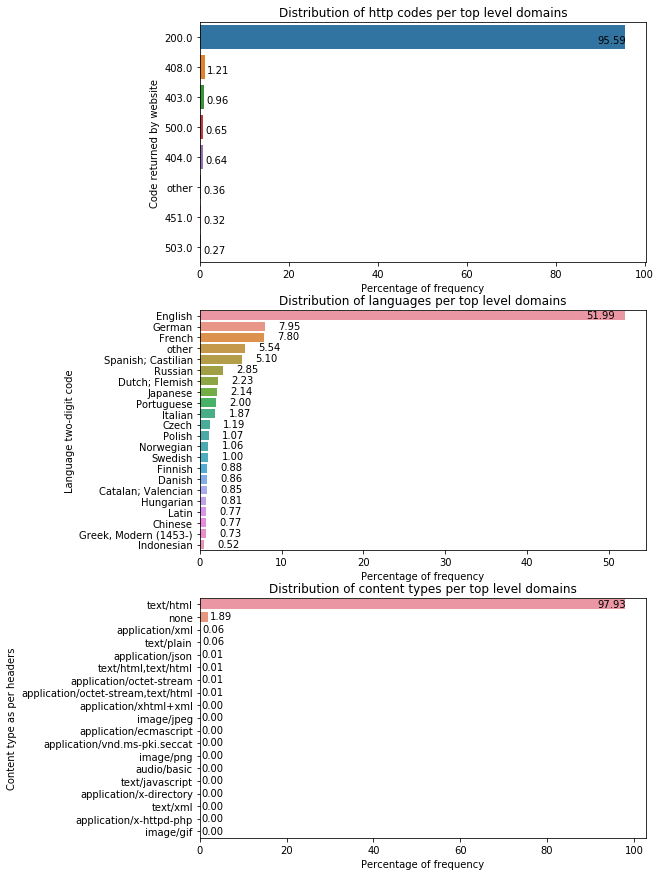

In [ ]:
reference_urls_codes = netloc_url_attrs_df['code'].value_counts(dropna=False, normalize=True).reset_index()
reference_urls_codes['code'] = reference_urls_codes['code']*100
reference_urls_codes.columns = ['code','per']
reference_urls_codes = aggregate_other(reference_urls_codes, by='code', count_name = 'per', other_thr=0.1)
fig, ax = plt.subplots(3,1,figsize=[8,15])

g = sns.barplot(y='code', x='per', data = reference_urls_codes, ax=ax[0], orient='h')
g.set_title("Distribution of http codes per top level domains")
g.set(ylabel='Code returned by website', xlabel='Percentage of frequency')

for p in g.patches:
    width = p.get_width()
    g.text(width + 3 if width < 20 else width - 3 ,
            p.get_y()+p.get_height()/2. + 0.2,
            '{:1.2f}'.format(width),
            ha="center")

non_langs = ['error','no content-type','no body','not text/html','parsing error','connection error on reading']
reference_urls_lan = netloc_url_attrs_df[netloc_url_attrs_df['language_crawl']\
                    .apply(lambda x: x not in non_langs)]['language_crawl']\
                    .apply(lambda x :ast.literal_eval(x)[0])\
                    .value_counts(dropna=False, normalize=True).reset_index()

reference_urls_lan['language_crawl'] = reference_urls_lan['language_crawl']*100
reference_urls_lan = aggregate_other(reference_urls_lan, by='index', count_name = 'language_crawl', other_thr=0.5)
language_codes = dict(languages_and_countries.languages)
reference_urls_lan['label'] = reference_urls_lan['index'].transform(lambda x: language_codes[x] if x != 'other' else x)

g = sns.barplot(y='label', x='language_crawl', data = reference_urls_lan, ax=ax[1])
g.set_title("Distribution of languages per top level domains")
g.set(ylabel='Language two-digit code', xlabel='Percentage of frequency')

for p in g.patches:
    width = p.get_width()
    g.text(width + 3 if width < 20 else width - 3 ,
            p.get_y()+p.get_height()/2. + 0.2,
            '{:1.2f}'.format(width),
            ha="center")
    
reference_urls_type = netloc_url_attrs_df['content-type']\
    .apply(lambda x : x.replace(' ','').lower().split(';')[0] if x != '' else 'none')\
    .value_counts(dropna=False, normalize=True).reset_index()
reference_urls_type['content-type'] = reference_urls_type['content-type']*100
g = sns.barplot(y='index', x='content-type', data = reference_urls_type, ax=ax[2])
g.set_title("Distribution of content types per top level domains")
g.set(ylabel='Content type as per headers', xlabel='Percentage of frequency')

for p in g.patches:
    width = p.get_width()
    g.text(width + 3 if width < 20 else width - 3 ,
            p.get_y()+p.get_height()/2. + 0.2,
            '{:1.2f}'.format(width),
            ha="center")
    
plt.show()

## Checking http status and language for a sample of urls

In [ ]:
print("There are {} reference urls in the sample".format(reference_urls.shape[0]))
cl, me = .99, .01
print("To obtain a confidence interval of {} and a margin of error of {}, we need a sample of size {}.". format(
    cl,
    me,
    sampleSize(
        population_size = reference_urls.shape[0],
        margin_error=me,
        confidence_level=cl,
        sigma=1/2
    )
))

There are 6503032 reference urls in the sample
To obtain a confidence interval of 0.99 and a margin of error of 0.01, we need a sample of size 16547.23003814621.


In [ ]:
if update:
    n = 18000
    # This code takes samples a thousand at a time (1000)
    print('{} out of {} is {}%'.format(n,reference_urls.shape[0], n/reference_urls.shape[0]*100))
    reference_urls_sample = reference_urls.sample(n=n, random_state=42).reset_index(drop=True)
    for i in range(0,18):
        print('Trying chunck {}\n'.format(i))
       
        mp_http_checker(
            input_set = reference_urls_sample.loc[i*1000:(i+1)*1000-1].iterrows(),
            output_dest = 'data/sample_url_attrs/sample_{}.json'.format(i),
            by = 'reference_url',
            to_add=[],
            mp_listener = mp_listener_file,
            mp_prepro = mp_prepro_df
        )
        
        print('\n')

In [ ]:
sample_url_attrs_jsons = []
for i in range(18):
    with open('data/sample_url_attrs/sample_{}.json'.format(i),'rb') as f:
        sample_url_attrs_jsons.append(json.load(f))
sample_url_attrs_json = [item for sublist in sample_url_attrs_jsons for item in sublist]
sample_url_attrs_df = pd.DataFrame(sample_url_attrs_json).fillna('')
sample_url_attrs_df['language_crawl'] = sample_url_attrs_df['language_crawl'].transform(lambda x : x[0].lower())
sample_url_attrs_df

url  \
0      https://www.ebi.ac.uk/europepmc/webservices/re...   
1      https://www.ebi.ac.uk/europepmc/webservices/re...   
2      https://www.ebi.ac.uk/europepmc/webservices/re...   
3      https://www.ebi.ac.uk/europepmc/webservices/re...   
4      https://www.ebi.ac.uk/europepmc/webservices/re...   
...                                                  ...   
17995  http://www.cnki.com.cn/Article/CJFDTOTAL-KXTB1...   
17996  http://en.cnki.com.cn/Article_en/CJFDTOTAL-HXX...   
17997  http://www.cnki.com.cn/Article/CJFDTOTAL-KJYJ1...   
17998  http://www.cnki.com.cn/Article/CJFDTOTAL-ZGTS1...   
17999  http://www.cnki.com.cn/Article/CJFDTOTAL-WJYY1...   

                                               error_msg  code  \
0                                                   none   200   
1                                                   none   200   
2                                                   none   200   
3                                                   none   200   
4                                                   none   200   
...                                                  ...   ...   
17995  HTTPConnectionPool(host='www.cnki.com.cn', por...   408   
17996  HTTPConnectionPool(host='en.cnki.com.cn', port...   408   
17997  HTTPConnectionPool(host='www.cnki.com.cn', por...   408   
17998                                               none   408   
17999                                               none   200   

                         content-type  \
0      application/json;charset=UTF-8   
1      application/json;charset=UTF-8   
2      application/json;charset=UTF-8   
3      application/json;charset=UTF-8   
4      application/json;charset=UTF-8   
...                               ...   
17995                                   
17996                                   
17997                                   
17998                       text/html   
17999        text/html; charset=utf-8   

                                               final_url            reason  \
0      https://www.ebi.ac.uk/europepmc/webservices/re...                OK   
1      https://www.ebi.ac.uk/europepmc/webservices/re...                OK   
2      https://www.ebi.ac.uk/europepmc/webservices/re...                OK   
3      https://www.ebi.ac.uk/europepmc/webservices/re...                OK   
4      https://www.ebi.ac.uk/europepmc/webservices/re...                OK   
...                                                  ...               ...   
17995                                                              timeout   
17996                                                              timeout   
17997                                                              timeout   
17998  http://www.cnki.com.cn/Article/CJFDTOTAL-ZGTS1...  Request Time-out   
17999  http://www.cnki.com.cn/Article/CJFDTOTAL-WJYY1...                OK   

      language_crawl  
0                 en  
1                 en  
2                 en  
3                 en  
4                 en  
...              ...  
17995              n  
17996              n  
17997              n  
17998             en  
17999             zh  

[18000 rows x 7 columns]

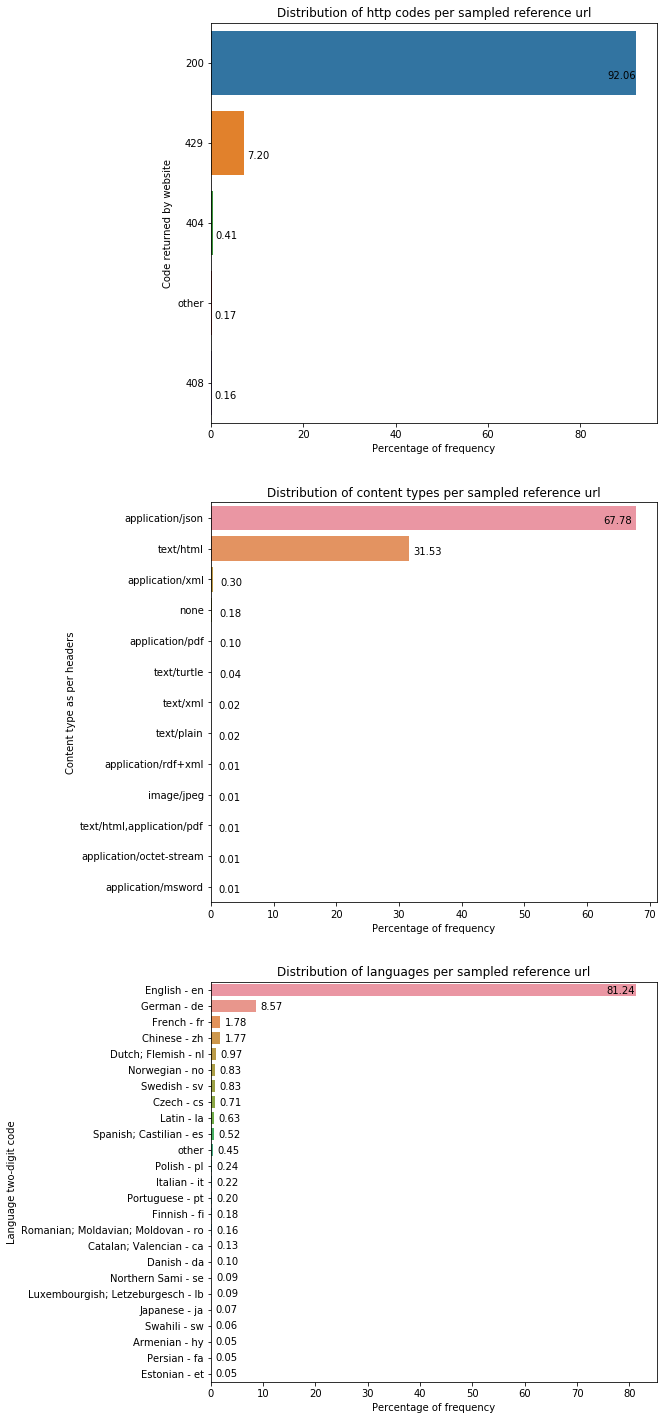

In [ ]:
reference_urls_codes = sample_url_attrs_df['code'].value_counts(dropna=False, normalize=True).reset_index()
reference_urls_codes['code'] = reference_urls_codes['code']*100
reference_urls_codes = aggregate_other(reference_urls_codes, by='index', count_name = 'code', other_thr=0.1)
fig, ax = plt.subplots(3,1,figsize=[8,25])

g = sns.barplot(y='index', x='code', data = reference_urls_codes, ax=ax[0], orient='h')
g.set_title("Distribution of http codes per sampled reference url")
g.set(ylabel='Code returned by website', xlabel='Percentage of frequency')

for p in g.patches:
    width = p.get_width()
    g.text(width + 3 if width < 50 else width - 3 ,
            p.get_y()+p.get_height()/2. + 0.2,
            '{:1.2f}'.format(width),
            ha="center")

reference_urls_type = sample_url_attrs_df['content-type']\
    .apply(lambda x : x.replace(' ','').lower().split(';')[0] if x != '' else 'none')\
    .value_counts(dropna=False, normalize=True).reset_index()
reference_urls_type['index'] = reference_urls_type['index'].apply(lambda x: x[:30])
reference_urls_type['content-type'] = reference_urls_type['content-type']*100

g = sns.barplot(y='index', x='content-type', data = reference_urls_type, ax=ax[1])
g.set_title("Distribution of content types per sampled reference url")
g.set(ylabel='Content type as per headers', xlabel='Percentage of frequency')

for p in g.patches:
    width = p.get_width()
    g.text(width + 3 if width < 50 else width - 3 ,
            p.get_y()+p.get_height()/2. + 0.2,
            '{:1.2f}'.format(width),
            ha="center")

#--------------------------------------------------------------

non_langs = ['error','n', 'no content-type','no body','not text/html','parsing error','connection error on reading']

reference_urls_lan = sample_url_attrs_df[sample_url_attrs_df['language_crawl']\
                        .apply(lambda x: x not in non_langs)]['language_crawl']\
                        .value_counts(dropna=False, normalize=True).reset_index()

reference_urls_lan['language_crawl'] = reference_urls_lan['language_crawl']*100
reference_urls_lan = aggregate_other(reference_urls_lan, by='index', count_name = 'language_crawl', other_thr=0.05)
language_codes = dict(languages_and_countries.languages)
reference_urls_lan['label'] = reference_urls_lan['index'].transform(lambda x: language_codes[x]+' - '+x if x in language_codes else x)
#
g = sns.barplot(y='label', x='language_crawl', data = reference_urls_lan, ax=ax[2])
g.set_title("Distribution of languages per sampled reference url")
g.set(ylabel='Language two-digit code', xlabel='Percentage of frequency')

for p in g.patches:
    width = p.get_width()
    g.text(width + 3 if width < 50 else width - 3 ,
            p.get_y()+p.get_height()/2. + 0.2,
            '{:1.2f}'.format(width),
            ha="center")
    
# TEXT/HTML TYPES ONLY 
#reference_urls_lan = sample_url_attrs_df[sample_url_attrs_df['content-type'] == 'text/html']
#reference_urls_lan = reference_urls_lan[sample_url_attrs_df['language_crawl']\
#                        .apply(lambda x: x not in non_langs)]['language_crawl']\
#                        .value_counts(dropna=False, normalize=True).reset_index()
#
#reference_urls_lan['language_crawl'] = reference_urls_lan['language_crawl']*100
#reference_urls_lan = aggregate_other(reference_urls_lan, by='index', count_name = 'language_crawl', other_thr=0.5)
#language_codes = dict(languages_and_countries.languages)
#reference_urls_lan['label'] = reference_urls_lan['index'].transform(lambda x: language_codes[x]+' - '+x if x in language_codes else x)
#
#g = sns.barplot(y='label', x='language_crawl', data = reference_urls_lan, ax=ax[3])
#g.set_title("Distribution of languages per sampled reference url")
#g.set(ylabel='Language two-digit code', xlabel='Percentage of frequency')

plt.show()


# Getting links for internal and external references

THE ORDER OF PRIORITY IN GETTING A URL IS:
     - THE FIRST EXTERNAL URL AVIALABLE
     - INTERNAL URL FROM THE FIRST URL FORMATTER IN THE EXTERNAL ID
     - WIKIMEDIA IMPORT URL FROM THE IMPORTED FROM WIKIMEDIA PROPERTY
     - OFFICIAL URL OF THE STATED-IN ENTITY
     - URL TAKEN FROM THE FORMATTER-URL OF THE FIRST EXTERNAL ID OF THE STATED-IN ENTITY  
     - INFERRED FROM WIKIDATA ITEM

In [ ]:
if update:
    sql_cursor.execute(
        ''' select distinct reference_id from refs indexed by reference_id_index '''
    )
    reference_ids = pd.DataFrame(sql_cursor.fetchall())
    reference_ids.to_csv('data/reference_nodes_ids.csv', index=False)
else:
    reference_ids = pd.read_csv('data/reference_nodes_ids.csv', header=None)
reference_ids.columns = ['reference_id']
reference_ids

reference_id
0         000002dbdf8e9565a1fe3f537d2e51376bc64b2b
1         0000048dd8453fd234890d9ecd6817bc8f396ca2
2         0000055d75cd8a204353322d604b02b76bfc70ec
3         0000070f5d5a4ca6c545e0a45fdc1db9f620af8a
4         000008c2a34d9aa1e007eebc9861b0b8f864f262
...                                            ...
13371621  fffffaf4d49a4e29d9b475294e312bcf13f8d200
13371622  fffffafe9a8523f74b52544046896050d31c721a
13371623  fffffb0650f7ff26876155a1789d32704775404f
13371624  fffffb9b28545b263a207a860fbefe23bca41c15
13371625  ffffff37b16e20b3669700e84a2748fe73496201

[13371626 rows x 1 columns]

In [ ]:
logger_step1 = logging.getLogger('process_reference_node_urls')

from pprint import pprint
class AutoCheckException(Exception):
    def __init__(self, *args):
        if args:
            self.message = args[0]
        else:
            self.message = None

    def __str__(self):
        #print('calling str')
        if self.message:
            return 'AutoCheckException, {0} '.format(self.message)
        else:
            return 'AutoCheckException has been raised'
        
def process_reference_node_urls(reference_block_hash, verbose=False):
    try:
        # GETTING ALL ATTRIBUTES OF THE NODE
        sql_cursor.execute('''
            select * from refs
            where reference_id = '{0}'
        '''.format(reference_block_hash))
        ref_node = sql_cursor.fetchall()
        if verbose:
            pprint(ref_node)
        attrs = {
            'reference_block_hash': reference_block_hash,
            'url' : None,
            'url_type' : None,
            'is_inferred_from': None,
            'stated_in' : [],
            'external_id_prop' : None,
            'external_id' : None,
            'internal_urls' : None,
            'external_url' : None,
            'wikimedia_import_urls' : [],
            'retrieved': None,
            'publication_date' : None,
            'ref_node': None
        }
        # PARSING THE ATTRIBUTES OF THE NODE
        for snak in ref_node:
            snak_value = ast.literal_eval(snak[4])
            if verbose:
                print(snak_value)
            if snak[3] in ('external-id','string'):
                if snak[3] == 'external-id': #ALREADY RECORD THESE IF IT IS EXTERNAL ID TYPE
                    if attrs['external_id'] is not None:
                        #raise AutoCheckException('More than a single external id on ref node:\n{}'.format(ref_node))
                        continue
                    else:
                        attrs['external_id'] = snak_value['value']
                        attrs['external_id_prop'] = snak[1]
                external_id_prop = get_entity(snak[1])
                if 'P1630' in external_id_prop['claims']:
                    if snak[3] == 'string': #RECORD THESE NOW IF IT IS STRING TYPE
                        if attrs['external_id'] is not None:
                            #raise AutoCheckException('More than a single external id on ref node:\n{}'.format(ref_node))
                            continue
                        else:
                            attrs['external_id'] = snak_value['value']
                            attrs['external_id_prop'] = snak[1]
                    formatter_urls = [p['mainsnak']['datavalue']['value'] for p in external_id_prop['claims']['P1630']]
                    attrs['internal_urls'] = [p.replace('$1', attrs['external_id']) for p in formatter_urls]                   
            elif snak[1] == 'P248' and snak[3] == 'wikibase-item':
                attrs['stated_in'].append(snak_value['value']['id'])
            elif snak[1] == 'P854' and snak[3] == 'url':            
                if attrs['external_url'] != None:
                    continue
                    #raise AutoCheckException('More than a single url on ref node:\n{}'.format(ref_node))
                else:
                    attrs['external_url'] = snak_value['value']
            elif snak[1] == 'P813' and snak[3] == 'time':
                if attrs['retrieved'] != None:
                    continue
                    #raise AutoCheckException('More than a single retrieved on ref node:\n{}'.format(ref_node))
                else:
                    attrs['retrieved'] = snak_value['value']
            elif snak[1] == 'P577' and snak[3] == 'time':
                if attrs['publication_date'] is not None:
                    continue
                    #raise AutoCheckException('More than a single publication date on ref node:\n{}'.format(ref_node))
                else:
                    attrs['publication_date'] = snak_value['value']
            elif snak[1] == 'P4656' and snak[3] == 'url':
                attrs['wikimedia_import_urls'].append(snak_value['value'])
            elif snak[1] == 'P3452' and snak[3] == 'wikibase-item':
                if attrs['is_inferred_from'] is not None:
                    continue
                    #raise AutoCheckException('More than a single inferred from on ref node:\n{}'.format(ref_node))
                else:
                    attrs['is_inferred_from'] = snak_value['value']['id']

        if attrs['external_url']:
            attrs['url'] = attrs['external_url']
            attrs['url_type'] = 'external_url'
        elif attrs['internal_urls']:
            attrs['url'] = attrs['internal_urls'][0]
            attrs['url_type'] = 'internal_url'
        elif len(attrs['wikimedia_import_urls']) > 0:
            attrs['url'] = attrs['wikimedia_import_urls'][0]
            attrs['url_type'] = 'wikimedia_import_url'

        if attrs['url'] is None:
            if len(attrs['stated_in']) > 0:
                # REFERENCES MAY HAVE MULTIPLE STATED_IN, BUT WE ONLY USE THE FIRST ONE. MENTION THAT IN PAPER.
                stated_in_entity = get_entity(attrs['stated_in'][0])
                if 'P856' in stated_in_entity['claims']:
                    attrs['url'] = stated_in_entity['claims']['P856'][0]['mainsnak']['datavalue']['value']
                    attrs['url_type'] = 'stated_in_official_url'
                else:
                    for claim in [claimset[0] for claimset in stated_in_entity['claims'].values() if len(claimset)==1]:
                        # STATED IN ITENS MAY HAVE MORE THAN ONE EXTERNAL ID, BUT WE ONLY TAKE THE FIRST THAT WORKS
                        if claim['mainsnak']['datatype'] == 'external-id' and claim['mainsnak']['snaktype'] not in ['novalue','somevalue']:
                            external_id_prop_2 = get_entity(claim['mainsnak']['property'])
                            if 'P1630' in external_id_prop_2['claims']:
                                attrs['url'] = external_id_prop_2['claims']['P1630'][0]['mainsnak']['datavalue']['value'].\
                                    replace(
                                        '$1',
                                        claim['mainsnak']['datavalue']['value']
                                    )
                                attrs['url_type'] = 'stated_in_identifier_url'
                                break

        if attrs['url'] is None and attrs['is_inferred_from'] != None:
            attrs['url'] = 'https://www.wikidata.org/wiki/' + attrs['is_inferred_from']
            attrs['url_type'] = 'inferred_from_wikidata'       


        attrs['stated_in'] = ','.join(attrs['stated_in']) if len(attrs['stated_in']) > 0 else None
        attrs['ref_node'] = ref_node

        return attrs
    except KeyboardInterrupt:
        raise
    except Exception as e:
        logger_step1.exception('Exception occured when processing urls from node {}:'.format(reference_block_hash))
        return None

In [ ]:
reference_ids_sample = reference_ids.sample(n=5).reset_index(drop=True)

attrs_list = []
for row in reference_ids_sample.iterrows():
    attrs_list.append(process_reference_node_urls(row[1]['reference_id']))
    
reference_ids_sample_urls = pd.DataFrame(attrs_list)
reference_ids_sample_urls

reference_block_hash  \
0  2a11604272cfec1a00efebc0ce28013422f51f2e   
1  309c60355502c1fa67b6ebc0cd902b03ad81c207   
2  eb2171051c3954f3f14a959e3b59fbd0c0bb429d   
3  ba3eb58526d1ce8fc8063f3a06572730d3df9949   
4  16a7eab7685eebf53e653e093d12ba4ced6c0ded   

                                                 url      url_type  \
0           https://pubmed.ncbi.nlm.nih.gov/15999155  internal_url   
1           https://pubmed.ncbi.nlm.nih.gov/20978816  internal_url   
2                     https://viaf.org/viaf/41801744  internal_url   
3               https://rkd.nl/explore/artists/25157  external_url   
4  http://am.adlibhosting.com/amonline/details/co...  external_url   

  is_inferred_from  stated_in external_id_prop external_id  \
0             None   Q5412157             P698    15999155   
1             None   Q5412157             P698    20978816   
2             None       None             P214    41801744   
3             None  Q17299517             None        None   
4             None       None             None        None   

                                       internal_urls  \
0  [https://pubmed.ncbi.nlm.nih.gov/15999155, htt...   
1  [https://pubmed.ncbi.nlm.nih.gov/20978816, htt...   
2                   [https://viaf.org/viaf/41801744]   
3                                               None   
4                                               None   

                                        external_url wikimedia_import_urls  \
0                                               None                    []   
1                                               None                    []   
2                                               None                    []   
3               https://rkd.nl/explore/artists/25157                    []   
4  http://am.adlibhosting.com/amonline/details/co...                    []   

                                           retrieved publication_date  \
0  {'time': '+2017-11-01T00:00:00Z', 'timezone': ...             None   
1  {'time': '+2017-08-01T00:00:00Z', 'timezone': ...             None   
2                                               None             None   
3  {'time': '+2017-08-23T00:00:00Z', 'timezone': ...             None   
4  {'time': '+2017-12-03T00:00:00Z', 'timezone': ...             None   

                                            ref_node  
0  [(2a11604272cfec1a00efebc0ce28013422f51f2e, P2...  
1  [(309c60355502c1fa67b6ebc0cd902b03ad81c207, P2...  
2  [(eb2171051c3954f3f14a959e3b59fbd0c0bb429d, P2...  
3  [(ba3eb58526d1ce8fc8063f3a06572730d3df9949, P2...  
4  [(16a7eab7685eebf53e653e093d12ba4ced6c0ded, P8...

# ANALYZING A REPRESENTATIVE SAMPLE

This is:
- Generating a representative sample;
- Analyzing some metrics on it;

In [ ]:
print('There are about {} individual reference nodes in 100% of Wikidata'.format(5*reference_ids.shape[0]))
print('A sample with a 99% confidence interval and a 5% margin would have to be at least of size:\n{}'.format(
    round(sampleSize(population_size = 5*reference_ids.shape[0], margin_error = 0.01, confidence_level = 0.999))+1
))

There are about 66858130 individual reference nodes in 100% of Wikidata
A sample with a 99% confidence interval and a 5% margin would have to be at least of size:
27059.0


In [ ]:
if update:
    sample_size = 30000

    reference_ids_sample = reference_ids.sample(n=sample_size, random_state=42).reset_index(drop=True)

    attrs_list = []
    i = 0
    for row in reference_ids_sample.iterrows():
        if row[0]<i:
            continue
        print('{}%'.format((i+1)/sample_size*100) + ' '*15, end='\r')
        attrs_list.append(process_reference_node_urls(row[1]['reference_id']))
        i+=1

    reference_ids_sample_urls = pd.DataFrame(attrs_list)
    reference_ids_sample_urls.to_csv('data/reference_ids_sample_urls.csv',index=False)
else:
    reference_ids_sample_urls = pd.read_csv('data/reference_ids_sample_urls.csv').fillna('None')
reference_ids_sample_urls

reference_block_hash  \
0      fdf0b8f0849c8ebb730fdb94f346318d0e28c658   
1      8bc0812b630395efbc002320f3e413f0cd2d14c0   
2      f2dc58329cd520af8bcafe68035e07dbcf90261a   
3      b78281d9509c5d1ed955e612ad947d3ed54e5a1c   
4      292ee644c9159a430884ec220199a3d4579ae846   
...                                         ...   
29995  11235ced22b5a4446f208333f1a0b79ba0ef132a   
29996  229ab95ae2f4fd05a00570260d9a6510ca872b0e   
29997  26c491d399575275b43be29a0bbe648c809a0d69   
29998  53c76067ca15192ccd95e9f50473d68a7bcb40eb   
29999  177365e6e2e2c45772b8f710c293e5c6b36bcdc1   

                                                     url      url_type  \
0             https://viaf.org/viaf/88147602427757640745  internal_url   
1      https://www.ebi.ac.uk/europepmc/webservices/re...  external_url   
2                                                   None          None   
3      http://www.ebi.ac.uk/QuickGO/annotations?prote...  external_url   
4      https://echa.europa.eu/substance-information/-...  internal_url   
...                                                  ...           ...   
29995  https://api.crossref.org/works/10.1038%2FNRCAR...  external_url   
29996  https://www.ebi.ac.uk/europepmc/webservices/re...  external_url   
29997         http://europepmc.org/abstract/MED/23389808  external_url   
29998        https://www.ncbi.nlm.nih.gov/gene/100124441  internal_url   
29999         http://europepmc.org/abstract/MED/28684404  external_url   

      is_inferred_from  stated_in external_id_prop           external_id  \
0                 None       None             P214  88147602427757640745   
1                 None   Q5412157             P698              13546074   
2                 None       None             None                  None   
3                 None  Q28018111             None                  None   
4                 None  Q59911453            P2566           100.014.164   
...                ...        ...              ...                   ...   
29995             None   Q5188229             None                  None   
29996             None   Q5412157             P698               4492727   
29997             None   Q5412157             P698              23389808   
29998             None  Q20973051             P351             100124441   
29999             None   Q5412157             P698              28684404   

                                           internal_urls  \
0         ['https://viaf.org/viaf/88147602427757640745']   
1      ['https://pubmed.ncbi.nlm.nih.gov/13546074', '...   
2                                                   None   
3                                                   None   
4      ['https://echa.europa.eu/substance-information...   
...                                                  ...   
29995                                               None   
29996  ['https://pubmed.ncbi.nlm.nih.gov/4492727', 'h...   
29997  ['https://pubmed.ncbi.nlm.nih.gov/23389808', '...   
29998    ['https://www.ncbi.nlm.nih.gov/gene/100124441']   
29999  ['https://pubmed.ncbi.nlm.nih.gov/28684404', '...   

                                            external_url  \
0                                                   None   
1      https://www.ebi.ac.uk/europepmc/webservices/re...   
2                                                   None   
3      http://www.ebi.ac.uk/QuickGO/annotations?prote...   
4                                                   None   
...                                                  ...   
29995  https://api.crossref.org/works/10.1038%2FNRCAR...   
29996  https://www.ebi.ac.uk/europepmc/webservices/re...   
29997         http://europepmc.org/abstract/MED/23389808   
29998                                               None   
29999         http://europepmc.org/abstract/MED/28684404   

      wikimedia_import_urls  \
0                        []   
1                        []   
2                        []   
3                        []   
4              

In [ ]:
if update:
    mp_http_checker(
            input_set = reference_ids_sample_urls.loc[:].iterrows(),
            output_dest = 'data/reference_ids_sample_urls_attrs.json',
            by = 'url',
            to_add=['reference_block_hash'],
            mp_listener = mp_listener_file,
            mp_prepro = mp_prepro_df
        )
with open('data/reference_ids_sample_urls_attrs.json','rb') as f:
    reference_ids_sample_urls_attrs = json.load(f)    
len(reference_ids_sample_urls_attrs)
reference_ids_sample_urls_attrs = pd.DataFrame(reference_ids_sample_urls_attrs)
reference_ids_sample_urls_attrs = reference_ids_sample_urls_attrs.set_index('reference_block_hash')
reference_ids_sample_urls_attrs.columns = ['url_get_access_attrs', 'error_msg', 'code', 'content-type', 'final_url', 'reason','language_crawl']
reference_ids_sample_urls_attrs

url_get_access_attrs  \
reference_block_hash                                                                          
f2dc58329cd520af8bcafe68035e07dbcf90261a                                               None   
5d90faf8fe2439cce712844136866ebf87edd219  https://www.ebi.ac.uk/europepmc/webservices/re...   
f63ffeda70d9e8b9ab4a997653983a94363cd126         http://europepmc.org/abstract/MED/21924678   
76f7b375034746e27f3657463315169c0099d87a  https://www.ebi.ac.uk/europepmc/webservices/re...   
d135c0f129105a39f463bbf1ab36988135cc3af5  https://www.ebi.ac.uk/europepmc/webservices/re...   
...                                                                                     ...   
8ae53a63bf56f3155819b68954b4bf3e67ca8c35                           http://geonames.nga.mil/   
53c76067ca15192ccd95e9f50473d68a7bcb40eb        https://www.ncbi.nlm.nih.gov/gene/100124441   
494d8b3c72e416d64a2dd945297fd6537445bcd0                    https://d-nb.info/gnd/123253284   
7518bc8d6a56aa50c3ae6c3523ce40ff0986de86                    https://d-nb.info/gnd/116053143   
41be66862322c1b3ed9656ca8a560d006bb05355  http://europeana.eu/portal/record/07101/K_702....   

                                         error_msg   code  \
reference_block_hash                                        
f2dc58329cd520af8bcafe68035e07dbcf90261a      None    NaN   
5d90faf8fe2439cce712844136866ebf87edd219      none  200.0   
f63ffeda70d9e8b9ab4a997653983a94363cd126      none  200.0   
76f7b375034746e27f3657463315169c0099d87a      none  200.0   
d135c0f129105a39f463bbf1ab36988135cc3af5      none  200.0   
...                                            ...    ...   
8ae53a63bf56f3155819b68954b4bf3e67ca8c35      none  200.0   
53c76067ca15192ccd95e9f50473d68a7bcb40eb      none  200.0   
494d8b3c72e416d64a2dd945297fd6537445bcd0      none  200.0   
7518bc8d6a56aa50c3ae6c3523ce40ff0986de86      none  200.0   
41be66862322c1b3ed9656ca8a560d006bb05355      none  200.0   

                                                            content-type  \
reference_block_hash                                                       
f2dc58329cd520af8bcafe68035e07dbcf90261a                            None   
5d90faf8fe2439cce712844136866ebf87edd219  application/json;charset=UTF-8   
f63ffeda70d9e8b9ab4a997653983a94363cd126         text/html;charset=UTF-8   
76f7b375034746e27f3657463315169c0099d87a  application/json;charset=UTF-8   
d135c0f129105a39f463bbf1ab36988135cc3af5  application/json;charset=UTF-8   
...                                                                  ...   
8ae53a63bf56f3155819b68954b4bf3e67ca8c35                       text/html   
53c76067ca15192ccd95e9f50473d68a7bcb40eb        text/html; charset=UTF-8   
494d8b3c72e416d64a2dd945297fd6537445bcd0         text/html;charset=UTF-8   
7518bc8d6a56aa50c3ae6c3523ce40ff0986de86         text/html;charset=UTF-8   
41be66862322c1b3ed9656ca8a560d006bb05355        text/html; charset=utf-8   

                                                                                  final_url  \
reference_block_hash                                                                          
f2dc58329cd520af8bcafe68035e07dbcf90261a                                               None   
5d90faf8fe2439cce712844136866ebf87edd219  https://www.ebi.ac.uk/europepmc/webservices/re...   
f63ffeda70d9e8b9ab4a997653983a94363cd126          http://europepmc.org/article/MED/21924678   
76f7b375034746e27f3657463315169c0099d87a  https://www.ebi.ac.uk/europepmc/webservices/re...   
d135c0f129105a39f463bbf1ab36988135cc3af5  https://www.ebi.ac.uk/europepmc/webservices/re...   
...                                                                                     ...   
8ae53a63bf56f3155819b68954b4bf3e67ca8c35                 https://geonames.nga.mil/gns/html/   
53c76067ca15192ccd95e9f50473d68a7bcb40eb        https://www.ncbi.nlm.nih.gov/gene/100124441   
494d8b3c72e416d64a2dd945297fd6537445bcd0  https://portal.dnb.de/opac.htm?method=simpleSe...   
7518bc8

In [ ]:
# Join both dfs
reference_ids_sample_urls_joined = reference_ids_sample_urls.join(reference_ids_sample_urls_attrs,on='reference_block_hash')
reference_ids_sample_urls_joined['language_crawl'] = reference_ids_sample_urls_joined['language_crawl'].apply(lambda x : x[0].lower() if type(x) in [list,tuple] else x)
reference_ids_sample_urls_joined

reference_block_hash  \
0      fdf0b8f0849c8ebb730fdb94f346318d0e28c658   
1      8bc0812b630395efbc002320f3e413f0cd2d14c0   
2      f2dc58329cd520af8bcafe68035e07dbcf90261a   
3      b78281d9509c5d1ed955e612ad947d3ed54e5a1c   
4      292ee644c9159a430884ec220199a3d4579ae846   
...                                         ...   
29995  11235ced22b5a4446f208333f1a0b79ba0ef132a   
29996  229ab95ae2f4fd05a00570260d9a6510ca872b0e   
29997  26c491d399575275b43be29a0bbe648c809a0d69   
29998  53c76067ca15192ccd95e9f50473d68a7bcb40eb   
29999  177365e6e2e2c45772b8f710c293e5c6b36bcdc1   

                                                     url      url_type  \
0             https://viaf.org/viaf/88147602427757640745  internal_url   
1      https://www.ebi.ac.uk/europepmc/webservices/re...  external_url   
2                                                   None          None   
3      http://www.ebi.ac.uk/QuickGO/annotations?prote...  external_url   
4      https://echa.europa.eu/substance-information/-...  internal_url   
...                                                  ...           ...   
29995  https://api.crossref.org/works/10.1038%2FNRCAR...  external_url   
29996  https://www.ebi.ac.uk/europepmc/webservices/re...  external_url   
29997         http://europepmc.org/abstract/MED/23389808  external_url   
29998        https://www.ncbi.nlm.nih.gov/gene/100124441  internal_url   
29999         http://europepmc.org/abstract/MED/28684404  external_url   

      is_inferred_from  stated_in external_id_prop           external_id  \
0                 None       None             P214  88147602427757640745   
1                 None   Q5412157             P698              13546074   
2                 None       None             None                  None   
3                 None  Q28018111             None                  None   
4                 None  Q59911453            P2566           100.014.164   
...                ...        ...              ...                   ...   
29995             None   Q5188229             None                  None   
29996             None   Q5412157             P698               4492727   
29997             None   Q5412157             P698              23389808   
29998             None  Q20973051             P351             100124441   
29999             None   Q5412157             P698              28684404   

                                           internal_urls  \
0         ['https://viaf.org/viaf/88147602427757640745']   
1      ['https://pubmed.ncbi.nlm.nih.gov/13546074', '...   
2                                                   None   
3                                                   None   
4      ['https://echa.europa.eu/substance-information...   
...                                                  ...   
29995                                               None   
29996  ['https://pubmed.ncbi.nlm.nih.gov/4492727', 'h...   
29997  ['https://pubmed.ncbi.nlm.nih.gov/23389808', '...   
29998    ['https://www.ncbi.nlm.nih.gov/gene/100124441']   
29999  ['https://pubmed.ncbi.nlm.nih.gov/28684404', '...   

                                            external_url  \
0                                                   None   
1      https://www.ebi.ac.uk/europepmc/webservices/re...   
2                                                   None   
3      http://www.ebi.ac.uk/QuickGO/annotations?prote...   
4                                                   None   
...                                                  ...   
29995  https://api.crossref.org/works/10.1038%2FNRCAR...   
29996  https://www.ebi.ac.uk/europepmc/webservices/re...   
29997         http://europepmc.org/abstract/MED/23389808   
29998                                               None   
29999         http://europepmc.org/abstract/MED/28684404   

      wikimedia_import_urls  \
0                        []   
1                        []   
2                        []   
3                        []   
4              

In [ ]:
reference_ids_sample_urls_joined[reference_ids_sample_urls_joined.apply(lambda x : x['code'] == 200 and x['url'] != 'None', axis=1)].shape[0]/reference_ids_sample_urls_joined[reference_ids_sample_urls_joined.apply(lambda x : x['url'] != 'None', axis=1)].shape[0]

0.8771337898780691

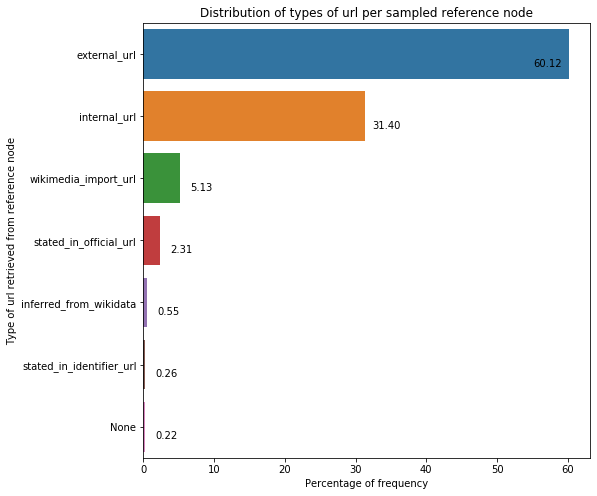

In [ ]:
reference_urls_urltypes = reference_ids_sample_urls_joined['url_type'].value_counts(dropna=False, normalize=True).reset_index()
reference_urls_urltypes['url_type'] = reference_urls_urltypes['url_type']*100
fig, ax = plt.subplots(1,1,figsize=[8,8])

g = sns.barplot(y='index', x='url_type', data = reference_urls_urltypes, ax=ax, orient='h')
g.set_title("Distribution of types of url per sampled reference node")
g.set(ylabel='Type of url retrieved from reference node', xlabel='Percentage of frequency')

for p in g.patches:
    width = p.get_width()
    g.text(width + 3 if width < 50 else width - 3 ,
            p.get_y()+p.get_height()/2. + 0.2,
            '{:1.2f}'.format(width),
            ha="center")
plt.show()

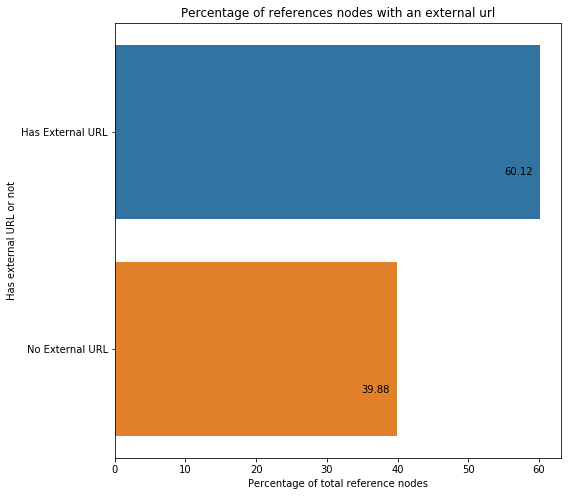

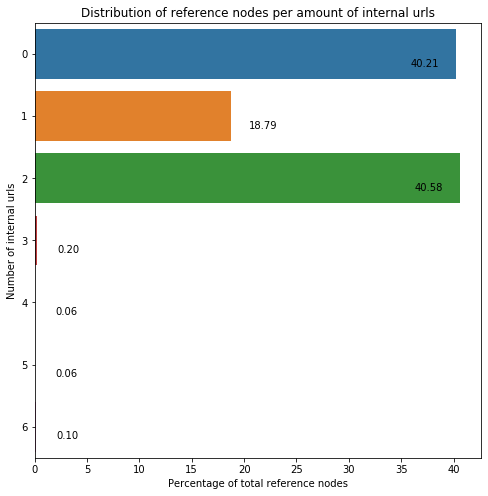

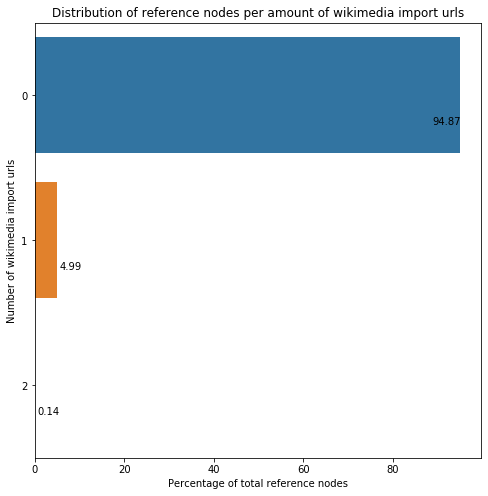

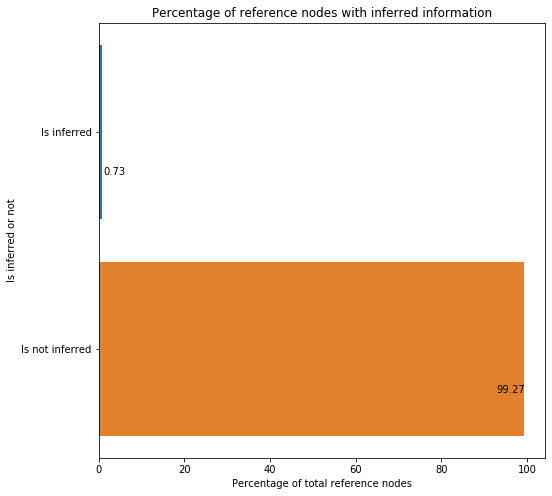

In [ ]:
def safe_eval(x):
    if type(x) in [dict,list,tuple]:
        return x
    elif type(x) == str:
        try:
            return ast.literal_eval(x)
        except:
            print(x)
            raise

def quick_plot(y, x, data, title, ylabel, xlabel, middle):   
    fig, ax = plt.subplots(1,1,figsize=[8,8])
    g = sns.barplot(y=y, x=x, data = data, ax=ax, orient='h')
    g.set_title(title)
    g.set(ylabel=ylabel, xlabel=xlabel)

    for p in g.patches:
        width = p.get_width()
        g.text(width + 3 if width < middle else width - 3 ,
                p.get_y()+p.get_height()/2. + 0.2,
                '{:1.2f}'.format(width),
                ha="center")
    plt.show()
    
has_external_url = reference_ids_sample_urls_joined['external_url']\
    .apply(lambda x : 'Has External URL' if x not in [None,'None'] else 'No External URL')\
    .value_counts(dropna=False, normalize=True)\
    .reset_index()
has_external_url['external_url'] *=100
has_external_url
quick_plot('index','external_url',has_external_url,'Percentage of references nodes with an external url','Has external URL or not','Percentage of total reference nodes',20)

has_internal_url = reference_ids_sample_urls_joined['internal_urls']\
    .apply(lambda x : len(safe_eval(x)) if x not in ['None',None] else 0)\
    .value_counts(dropna=False, normalize=True)\
    .reset_index().sort_values('index')
has_internal_url['internal_urls'] *=100
quick_plot('index','internal_urls',has_internal_url,'Distribution of reference nodes per amount of internal urls','Number of internal urls','Percentage of total reference nodes',20)

has_wikimedia_import_url = reference_ids_sample_urls_joined['wikimedia_import_urls']\
    .apply(lambda x : len(safe_eval(x)) if x not in ['None',None] else 0)\
    .value_counts(dropna=False, normalize=True)\
    .reset_index().sort_values('index')
has_wikimedia_import_url['wikimedia_import_urls'] *= 100
quick_plot('index','wikimedia_import_urls',has_wikimedia_import_url,'Distribution of reference nodes per amount of wikimedia import urls','Number of wikimedia import urls','Percentage of total reference nodes',20)

has_inferred_from = reference_ids_sample_urls_joined['is_inferred_from']\
    .apply(lambda x : 'Is inferred' if x not in [None,'None'] else 'Is not inferred')\
    .value_counts(dropna=False, normalize=True)\
    .reset_index().sort_values('index')
has_inferred_from['is_inferred_from'] *= 100
quick_plot('index','is_inferred_from',has_inferred_from,'Percentage of reference nodes with inferred information','Is inferred or not','Percentage of total reference nodes',20)

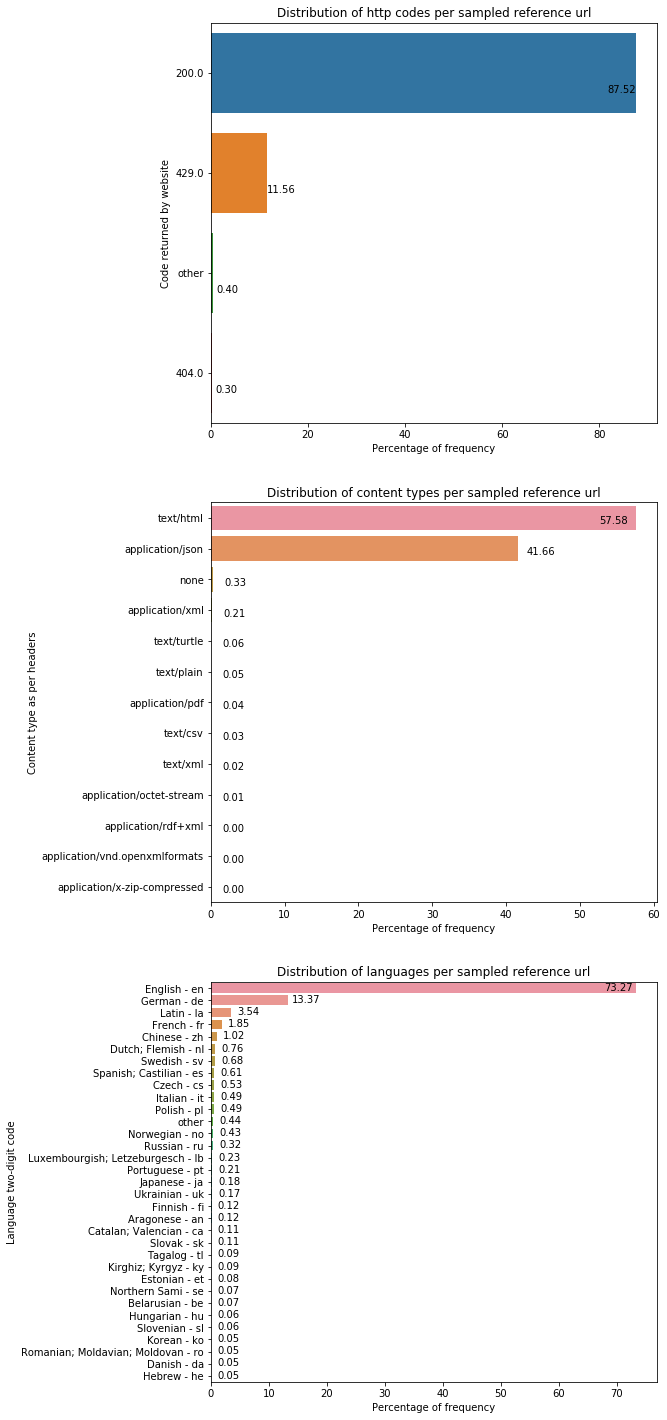

In [ ]:
reference_urls_codes = reference_ids_sample_urls_joined['code'].value_counts(dropna=False, normalize=True).reset_index()
reference_urls_codes['code'] = reference_urls_codes['code']*100
reference_urls_codes = aggregate_other(reference_urls_codes, by='index', count_name = 'code', other_thr=0.1)
fig, ax = plt.subplots(3,1,figsize=[8,25])

g = sns.barplot(y='index', x='code', data = reference_urls_codes, ax=ax[0], orient='h')
g.set_title("Distribution of http codes per sampled reference url")
g.set(ylabel='Code returned by website', xlabel='Percentage of frequency')

for p in g.patches:
    width = p.get_width()
    g.text(width + 3 if width < 50 else width - 3 ,
            p.get_y()+p.get_height()/2. + 0.2,
            '{:1.2f}'.format(width),
            ha="center")

reference_urls_type = reference_ids_sample_urls_joined['content-type']\
    .apply(lambda x : x.replace(' ','').lower().split(';')[0] if x not in ['','None',None] else 'none')\
    .value_counts(dropna=False, normalize=True).reset_index()
reference_urls_type['index'] = reference_urls_type['index'].apply(lambda x: x[:30])
reference_urls_type['content-type'] = reference_urls_type['content-type']*100

g = sns.barplot(y='index', x='content-type', data = reference_urls_type, ax=ax[1])
g.set_title("Distribution of content types per sampled reference url")
g.set(ylabel='Content type as per headers', xlabel='Percentage of frequency')

for p in g.patches:
    width = p.get_width()
    g.text(width + 3 if width < 50 else width - 3 ,
            p.get_y()+p.get_height()/2. + 0.2,
            '{:1.2f}'.format(width),
            ha="center")

#--------------------------------------------------------------

non_langs = ['error','n', 'no content-type','no body','not text/html','parsing error','connection error on reading']

reference_urls_lan = reference_ids_sample_urls_joined[reference_ids_sample_urls_joined['language_crawl']\
                        .apply(lambda x: x not in non_langs)]['language_crawl']\
                        .value_counts(dropna=False, normalize=True).reset_index()

reference_urls_lan['language_crawl'] = reference_urls_lan['language_crawl']*100
reference_urls_lan = aggregate_other(reference_urls_lan, by='index', count_name = 'language_crawl', other_thr=0.05)
language_codes = dict(languages_and_countries.languages)
reference_urls_lan['label'] = reference_urls_lan['index'].apply(lambda x: language_codes[x]+' - '+x if x in language_codes else x)
#
g = sns.barplot(y='label', x='language_crawl', data = reference_urls_lan, ax=ax[2])
g.set_title("Distribution of languages per sampled reference url")
g.set(ylabel='Language two-digit code', xlabel='Percentage of frequency')

for p in g.patches:
    width = p.get_width()
    g.text(width + 3 if width < 50 else width - 3 ,
            p.get_y()+p.get_height()/2. + 0.2,
            '{:1.2f}'.format(width),
            ha="center")

plt.show()


# CREATE CROWDSOURCING SAMPLES
In case we want to take 665 reference samples with a mix of target languages, we should re-do the graph above and exclude the non-target ones. This will give us the distribution of target-languages only, and thus we can run a crowdsourcing campaign of similar proportions.

The file with sampled and processed references is located at **reference_ids_sample_urls_notNone**

In [ ]:
#CREATE TWO TABLES ON THE DB FOR THIS, SELECT A SIZED SAMPLE WITH SEED=42 AND THEN, FOR EACH REFERENCE ID:
# - CHECK IF IT IS ALREADY PROCESSED FOR ACCESSIBLE URL AND PUT INTO AN 'ACCESSIBLE URL FOR REFS' TABLE
# - CHECK IF THE URL IS ALREADY CHECKED FOR STATUS AND LANGUAGE AND PUT INTO A 'STATUS URL FOR REFS' TABLE
# - USE A PROGRESS.TXT FILE FOR BOTH
# IF IT DOES NOT HAVE ENOUGH REFERENCES FOR THE TARGET LANGUAGES, GET MORE SAMPLES USING SEED=42
# THE STEPS ABOVE ARE BASICALLY REPEATING WHAT IS DONE FOR THE GETTING INTERNAL AND EXTERNAL LINKS AND
# THE REPRESENTATIVE SAMPLE STEPS ABOVE

In [ ]:
wikidata_db_processed = sqlite3.connect('/mnt/data/group3/wikidata/part/wikidata_processed_apr.db')
sql_cursor_proc = wikidata_db_processed.cursor()

In [ ]:
reference_ids = pd.read_csv('data/reference_nodes_ids.csv', header=None)
reference_ids.columns = ['reference_id']
reference_ids

reference_id
0         000002dbdf8e9565a1fe3f537d2e51376bc64b2b
1         0000048dd8453fd234890d9ecd6817bc8f396ca2
2         0000055d75cd8a204353322d604b02b76bfc70ec
3         0000070f5d5a4ca6c545e0a45fdc1db9f620af8a
4         000008c2a34d9aa1e007eebc9861b0b8f864f262
...                                            ...
13371621  fffffaf4d49a4e29d9b475294e312bcf13f8d200
13371622  fffffafe9a8523f74b52544046896050d31c721a
13371623  fffffb0650f7ff26876155a1789d32704775404f
13371624  fffffb9b28545b263a207a860fbefe23bca41c15
13371625  ffffff37b16e20b3669700e84a2748fe73496201

[13371626 rows x 1 columns]

## Step 1: Turning reference_id into extracted urls

For each sampled reference node we do the following processing.

In: A reference node id <br>
Out: A dictionary with the following fields:
- reference_id : The reference ID;
- url: The extracted url;
- url_type: The type of url (external, internal, imported, etc);
- is_inferred_from: Whether the reference is an inferrence from a wikimedia project resource;
- stated_in: If the reference is stated in somewhere, and where;
- external_id_prop: If the reference links to an external identifier and which one;
- internal_urls: List of internal urls the reference has, based on external ids and formatter urls;
- external_url: If the reference has an external url and which;
- wikimedia_import_urls: If the reference was imported from a wikimedia project, and where from;
- retrieved: Date the reference was retrieved at;
- publication_Date: Date the reference was published;
- ref_node: String representation of the reference node;

We aggregate the dictionaries into a database table **reference_nodes_to_urls**.

In [ ]:
sql_cursor_proc.execute('''
    select reference_id from reference_nodes_to_urls;
''')
reference_nodes_to_urls = [v[0] for v in sql_cursor_proc.fetchall()]
print('There are {} processed nodes into url sets'.format(len(reference_nodes_to_urls)))

sample_size = 600000 #THIS SIZE SHOULD BE BIG ENOUGH SO THAT YOU CAN EXTRACT AT LEAST THE NEEDED AMOUT OF
#REFERENCES FOR EACH LANGUAGE. IF THAT DOES NOT HAPPEN, RUN THIS AGAIN INCREASING THE SIZE.
reference_ids_sample = reference_ids.sample(n=sample_size, random_state=42).reset_index(drop=True)
attrs_list = []
try:
    for i, row in reference_ids_sample.iterrows():
        print('{}%'.format((i+1)/sample_size*100) + ' '*15, end='\r')
        if row['reference_id'] not in reference_nodes_to_urls:
            processed_node_urls = process_reference_node_urls(row['reference_id'])
            if processed_node_urls == None:
                continue
            sql_cursor_proc.execute('''
            INSERT INTO reference_nodes_to_urls(
                reference_id, url, url_type, is_inferred_from,
                stated_in, external_id_prop, external_id, internal_urls,
                external_url, wikimedia_import_urls, retrieved, publication_date, ref_node
            )
            VALUES($var,$var,$var,$var,$var,$var,$var,$var,$var,$var,$var,$var,$var)'''.replace('$var','?'), (
                [str(v) for v in list(processed_node_urls.values())]
            ))
finally:
    wikidata_db_processed.commit()

There are 599995 processed nodes into url sets


## Step 2: Parsing extracted urls for http and language codes

For each entry in the **reference_nodes_to_urls** table, we do the following.

In: The reference node id and url values of the table entry <br>
Out: A dictionary with the following fields:
- reference_id: The reference node ID;
- url: The url that was parsed, according to reference_nodes_to_urls;
- error_msg: An error message if there was one;
- code: The http code of the request;
- content-type: The type of content retrieved;
- final_url: The url after all redirects;
- reason: The reason returned in the http return object;
- language_crawl: The crawled language according to langdetect

We aggregate the dictionaries into a database table **reference_urls_parsed**.

In [ ]:
sql_cursor_proc.execute('''
    select reference_id from reference_urls_parsed;
''')
reference_urls_parsed = [v[0] for v in sql_cursor_proc.fetchall()]
print('There are {} parsed url sets'.format(len(reference_urls_parsed)))


def mp_listener_print(q, out):
    while 1:
        m = q.get()  
        if m == 'kill':
            print('bye')
            break              
        print(m)
            
def mp_listener_db(q, out):
    cursor = wikidata_db_processed.cursor()
    counter = 0
    try:
        while 1:
            m = q.get()
            if m == 'kill':
                wikidata_db_processed.commit()
                break
            cursor.execute('''
            INSERT INTO reference_urls_parsed(
                reference_id, url, error_msg, code, 'content-type', final_url, reason, language_crawl
            )
            VALUES($var,$var,$var,$var,$var,$var,$var,$var)'''.replace('$var','?'), (
                [
                    m['reference_id'],
                    m['url'],
                    m['error_msg'],
                    m['code'],
                    m['content-type'],
                    m['final_url'],
                    m['reason'],
                    m['language_crawl'][0].lower() if type(m['language_crawl']) in [list,tuple] else m['language_crawl']
                ]
            ))
            #wikidata_db_processed.commit()
            counter +=1
            if counter >= 1000:
                print('Comitting block of 1000')
                wikidata_db_processed.commit()
                counter = 0
    except:
        raise
        
            
def mp_prepro_db_reference_nodes_to_urls(line):
    if line[0] in reference_urls_parsed:
        return None # RETURNING NONE MAKES THE MASTER SKIP THIS ID WHEN ASSIGNING JOBS
    return {'reference_id':line[0],'url':line[1]}

if True:
    sql_cursor_proc.execute('''
        select * from reference_nodes_to_urls;
    ''')
    
    try:
        mp_http_checker(
            input_set = sql_cursor_proc,
            output_dest = None,
            by = 'url',
            to_add=['reference_id'],
            mp_listener = mp_listener_db,
            mp_prepro = mp_prepro_db_reference_nodes_to_urls
        )
    finally:
        print('Finally block: Commiting changes!')
        wikidata_db_processed.commit()
        

There are 228000 parsed url sets


Process ForkPoolWorker-25:
Traceback (most recent call last):
  File "/home/gabriela/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/gabriela/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/gabriela/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/gabriela/anaconda3/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/home/gabriela/anaconda3/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
Process ForkPoolWorker-2:
Process ForkPoolWorker-6:
Process ForkPoolWorker-5:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/gabriela/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File

Finally block: Commiting changes!


  File "/home/gabriela/anaconda3/lib/python3.7/multiprocessing/managers.py", line 819, in _callmethod
    kind, result = conn.recv()
Process ForkPoolWorker-23:
  File "/home/gabriela/anaconda3/lib/python3.7/multiprocessing/connection.py", line 250, in recv
    buf = self._recv_bytes()


FileNotFoundError: [Errno 2] No such file or directory

Process ForkPoolWorker-7:
  File "/home/gabriela/anaconda3/lib/python3.7/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/gabriela/anaconda3/lib/python3.7/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/gabriela/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/gabriela/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/gabriela/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/gabriela/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/gabriela/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "

  File "/home/gabriela/anaconda3/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/home/gabriela/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/gabriela/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/gabriela/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/gabriela/anaconda3/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/home/gabriela/anaconda3/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/home/gabriela/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/gabriela/anaconda3/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/home/gabriela/anaconda3/lib/python3.7/multiprocessing/pool.py", lin

## Steps 3 and 4
Steps 3 and 4 are detailed in the file ./Crowdsourcing/GenerateTaskSets.ipynb

## Sampling stats

In [ ]:
target_languages = ['en','es','nl','sv','pt','ja']
me = 0.05
cl = 0.95
for i, lan in reference_urls_lan[reference_urls_lan['index'].apply(lambda x : x in target_languages)].iterrows():
    size = 5*reference_ids.shape[0]*(lan['per']/100)
    print('There are about {} individual reference nodes in Wikidata on language {}'.format(
        size,
        color.BOLD + lan['label'] + color.END
    ))
    print('A sample with a {}% confidence level and a {}% margin would have to be at least of size: {}'.format(
        cl*100,
        me*100,
        color.BOLD + str(round(sampleSize(population_size = size, margin_error = me, confidence_level = cl))+1) + color.END
    ))
    
    sql_cursor_proc.execute('''
        select count(distinct reference_id) from reference_urls_parsed where language_crawl == '{}';
    '''.format(lan['index']))
    
    print('We currently have {} samples processed and parsed'.format(
        color.BOLD + str(sql_cursor_proc.fetchall()[0][0]) + color.END
    ))
    
    
    print('\n')
print('There are about {} individual reference nodes in Wikidata as a whole'.format(
    5*reference_ids.shape[0]
))
print('A sample with a {}% confidence level and a {}% margin would have to be at least of size: {}'.format(
    cl*100,
    me*100,
    color.BOLD + str(round(sampleSize(population_size = 5*reference_ids.shape[0], margin_error = me, confidence_level = cl))+1) + color.END
))

There are about 48987021.51349185 individual reference nodes in Wikidata on language English - en
A sample with a 95.0% confidence level and a 5.0% margin would have to be at least of size: 385
We currently have 191018 samples processed and parsed


There are about 511304.8280122896 individual reference nodes in Wikidata on language Dutch; Flemish - nl
A sample with a 95.0% confidence level and a 5.0% margin would have to be at least of size: 385
We currently have 1591 samples processed and parsed


There are about 453252.7514694096 individual reference nodes in Wikidata on language Swedish - sv
A sample with a 95.0% confidence level and a 5.0% margin would have to be at least of size: 385
We currently have 1398 samples processed and parsed


There are about 406364.53580016026 individual reference nodes in Wikidata on language Spanish; Castilian - es
A sample with a 95.0% confidence level and a 5.0% margin would have to be at least of size: 385
We currently have 1590 samples processed 

# Useful SPARQL Queries

SPARQL Endpoint: https://query.wikidata.org/

## Retrieve all statements where a certain reference node is used:

```
select ?s
where {
 ?s prov:wasDerivedFrom wdref:{reference_block_hash}.
 SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
}
```

## Retrieve all properties of a reference node:

```
select ?p ?ppLabel ?o ?oLabel
where {
 wdref:{reference_block_hash} ?p ?o.
 ?pp wikibase:reference ?p.
 ?pp a wikibase:Property.
 SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
}
```